In [51]:
# imports from custom library
import sys
sys.path.append('../../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import basics_library as baslib
from mlrefined_libraries import calculus_library as callib
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import linear_algebra_library as linlib
import autograd.numpy as np
import time
from autograd.util import flatten_func
from autograd import grad as compute_grad   # The only autograd function you may ever need
from matplotlib import gridspec

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Lecture 9: Optimization tricks part 1

In this lecture we talk about our first batch of new optimization tricks that can help us overcome common problems encountered when optimizing nonlinear supervised learners like neural networks.

Press the button 'Toggle code' below to toggle code on and off for entire this presentation.  

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

# Normalized Gradient Descent

- Thus far we have been using gradient descent steps of the form

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})
$$

- This is - more technically speaking - called *unnormalized gradient descent* - why this name?

- Because we only care about the descent *direction* when taking steps, and **not its magnitude**

- So technically speaking we can instead take steps in the unit-direction given by the negative gradient: i.e., $- \frac{\nabla g(\mathbf{w})}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2 }$

- Note that this means we normalize each partial derivative evaluation by the length of the entire gradient

$$
-\frac{\nabla g(\mathbf{w})}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2 } = 
\begin{bmatrix}
\frac{-\frac{\partial}{\partial w_1}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2} \\
\frac{-\frac{\partial}{\partial w_2}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2} \\
\vdots \\
\frac{-\frac{\partial}{\partial w_N}g\left(\mathbf{w}\right)}{\left\Vert \nabla g(\mathbf{w}) \right\Vert_2}
\end{bmatrix}
$$

- This is the *normalized gradient descent* step

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha\frac{\nabla g(\mathbf{w}^{k-1})}{\left\Vert \nabla g(\mathbf{w}^{k-1}) \right\Vert_2 }
$$

- Our original step is called *unnormalized gradient descent* because we do not normalize the negative gradient direction

$$
\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})
$$

- Whats the difference between them?

- In term of theoretical things (like convergence) = nothing

- Besides setting $\alpha \longleftarrow \frac{\alpha}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2}$ turns the unnormalized gradient descent step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g\left(\mathbf{w}^{\,k-1}\right)$ into a normalized one.

- However in terms of practical engineering usage = quite a bit!   Particularly when using a fixed steplength param $\alpha$ as we have been doing.

- First, notice the distance traveled at an *unnormalized gradient descent* step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha \nabla g(\mathbf{w}^{\,k-1})$

$$
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2  = \left\Vert -\alpha \nabla g\left(\mathbf{w}^{\,k-1}\right)\right\Vert_2 = \alpha\left\Vert \nabla g\left(\mathbf{w}^{\,k-1}\right) \right\Vert_2
$$

- That is, the distance traveled is equal to the steplength parameter $\alpha$ times the length of the gradient at $\mathbf{w}^{k-1}$

- Hence the parameter $\alpha$ only partially controls the length of each step, the gradient adaptively changes the distance we travel at each step

- **With convex functions:**  this forces initial steps to be quite large but afterwards we slow down a ton since the gradient is vanishing close to a minimum

- This behavior has been fine unless our convex functions have *long narrow valleys* leading to global minima

- **With non-convex functions:** this will force gradient descent to halt near *any stationary point*, including e.g., saddle points

- This behavior is highly undesirable - we want to find minima!

- Now notice the legnt of each step with the *normalized* form of gradient descent $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha\frac{\nabla g(\mathbf{w}^{k-1})}{\left\Vert \nabla g(\mathbf{w}^{k-1}) \right\Vert_2 }$

- The general length of the $k^{th}$ step is equal to

$$
\left\Vert \mathbf{w}^{\,k} - \mathbf{w}^{\,k-1} \right\Vert_2 = \left\Vert -\alpha \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2 = \alpha \left\Vert \frac{\nabla g(\mathbf{w}^{\,k-1})}{\left\Vert \nabla g(\mathbf{w}^{\,k-1}) \right\Vert_2 }\right\Vert_2 = \alpha
$$

- It is given *exactly* by the steplength parameter $\alpha$, and does not depend on the length of the gradient

- A fixed value for $\alpha$ can be used, but also diinishing steplength like $\alpha = \frac{1}{k}$ used to ensure convergence 

- Hence the normalized descent step $\mathbf{w}^{\,k} = \mathbf{w}^{\,k-1} - \alpha\frac{\nabla g(\mathbf{w}^{k-1})}{\left\Vert \nabla g(\mathbf{w}^{k-1}) \right\Vert_2 }$ will **not** suffer from 

     - Slowing down on a convex function (or any long narrow valley) due to a vanishing gradient

    - Getting caught in the non-minimum stationary point (e.g., a saddle point) of a non-convex function

## Examples applying normalized gradient descent

- Helps blast through saddle points of non-convex functions


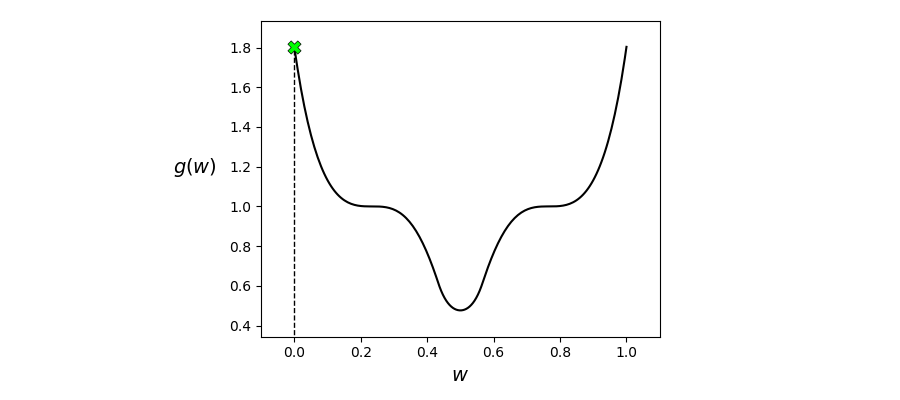
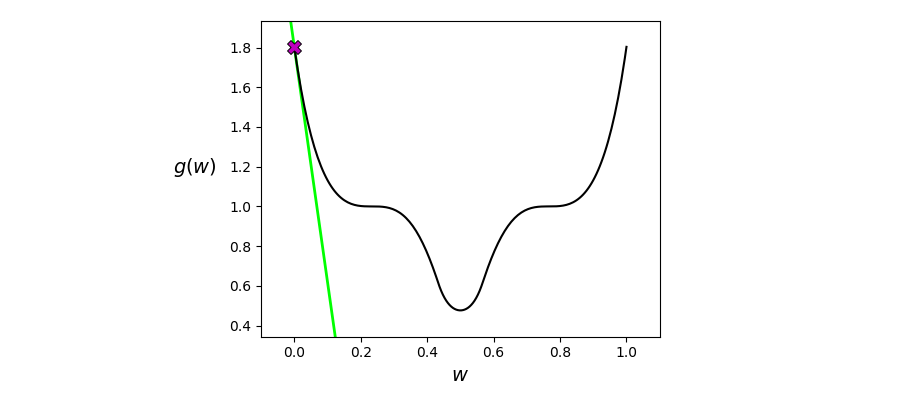
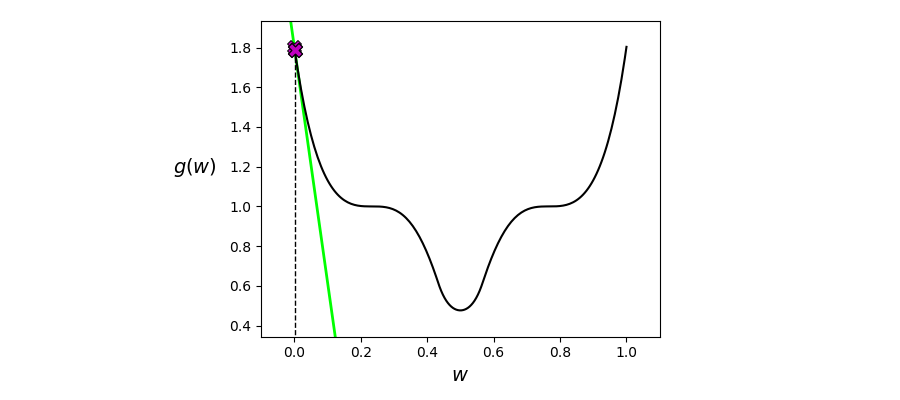
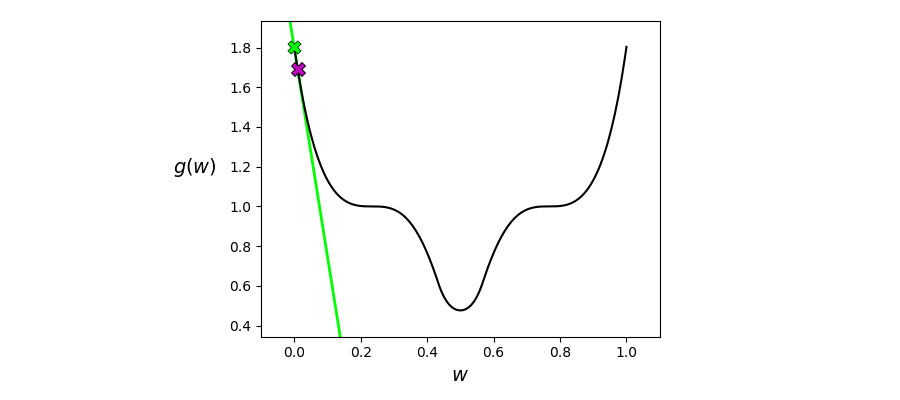
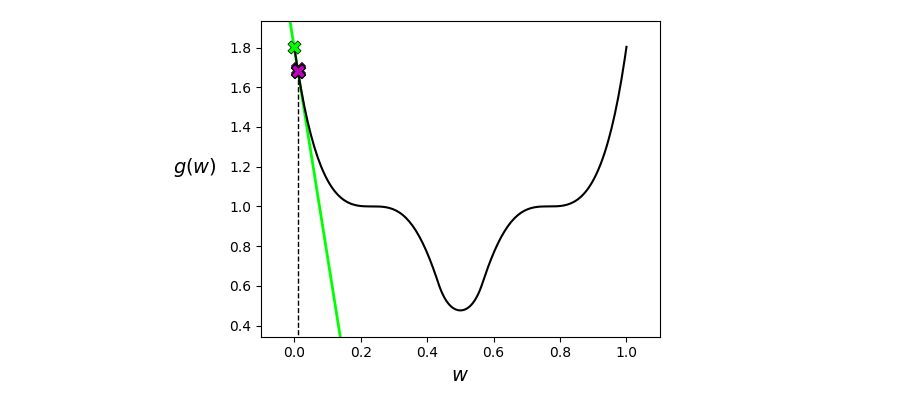
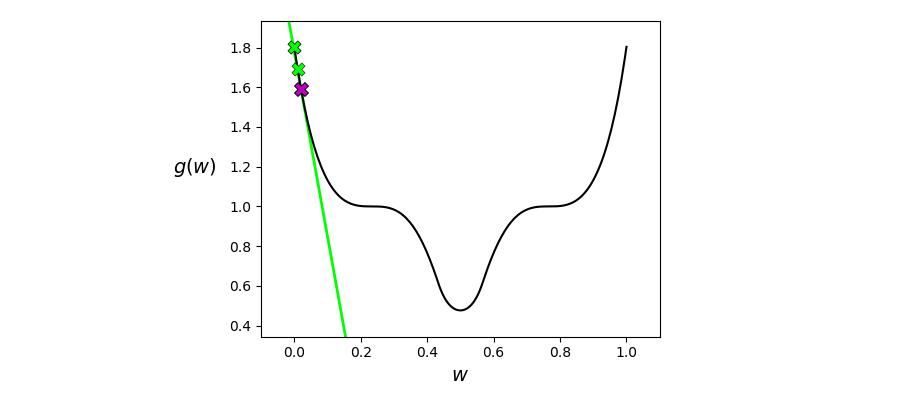
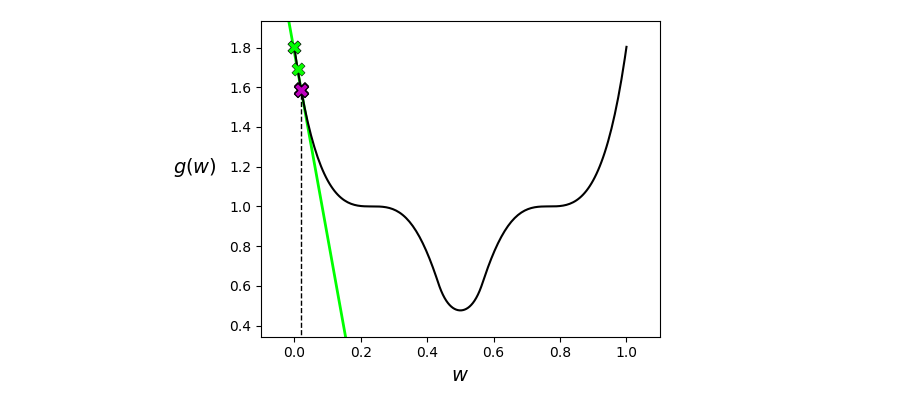
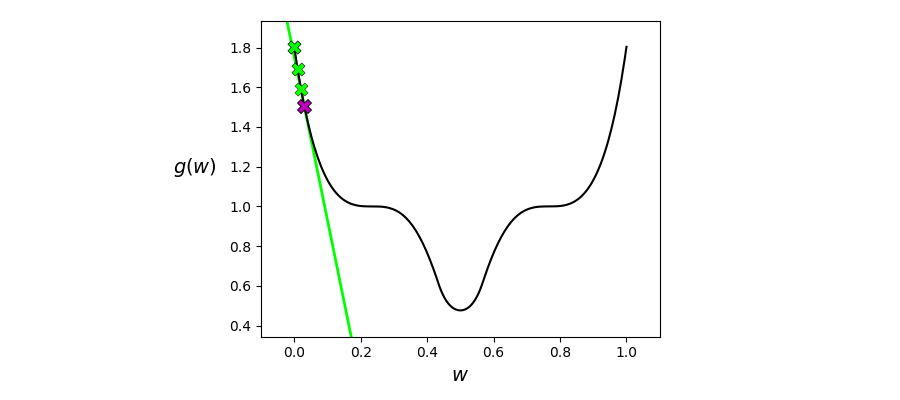
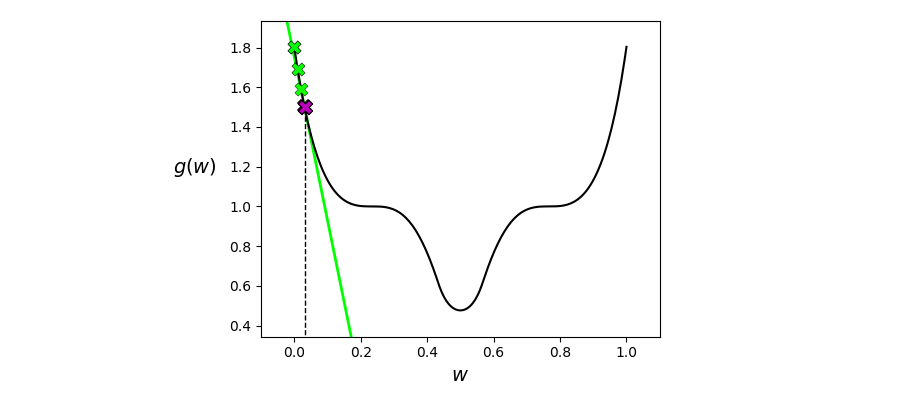
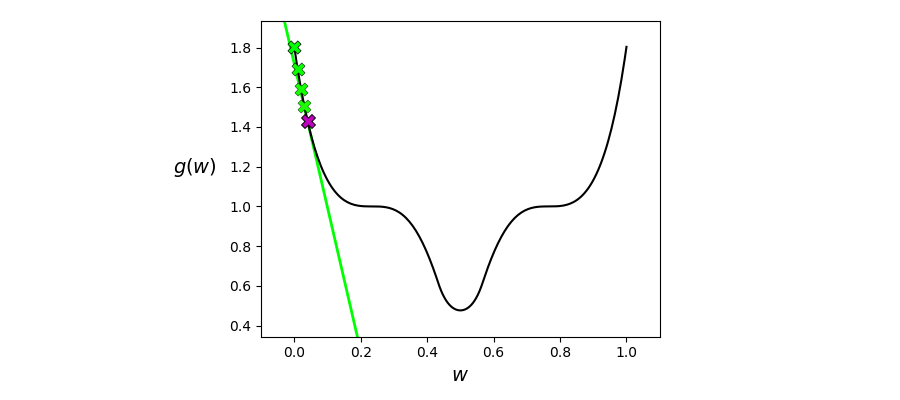
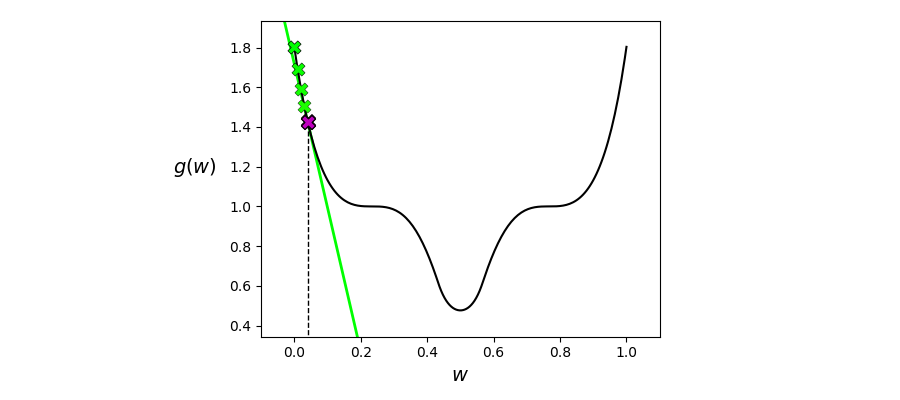
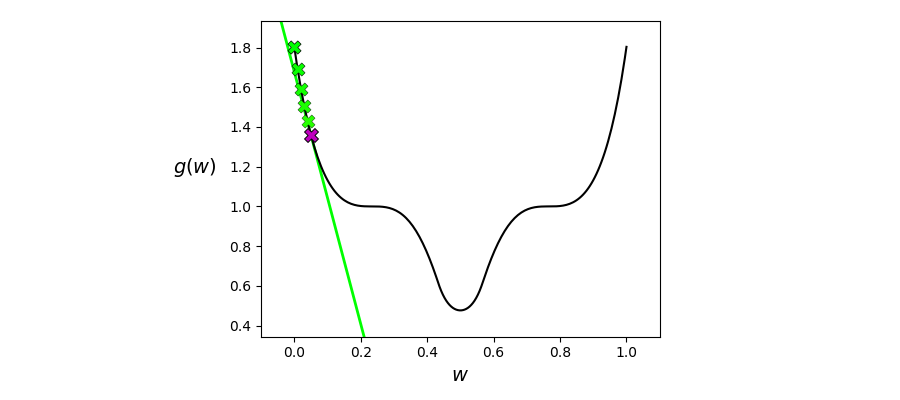
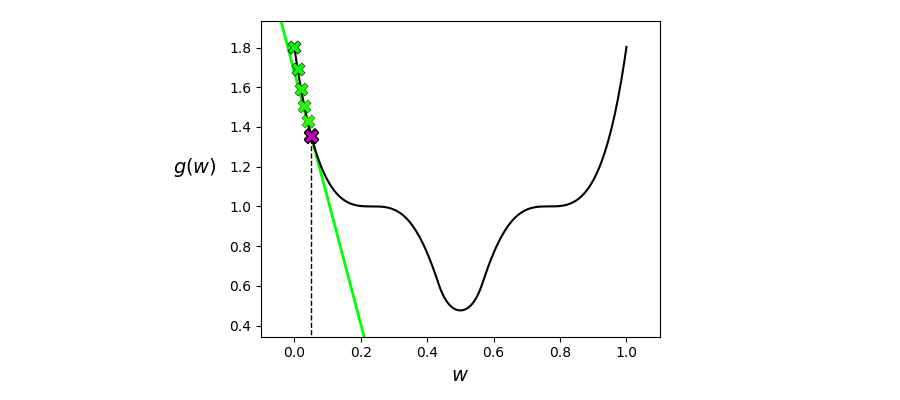
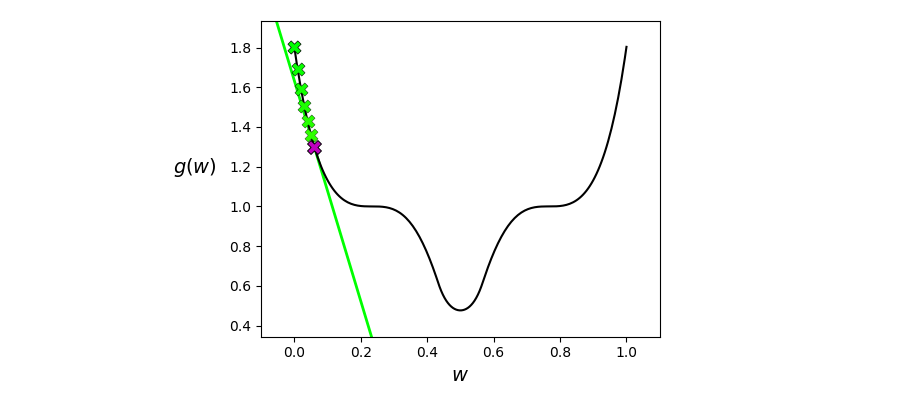
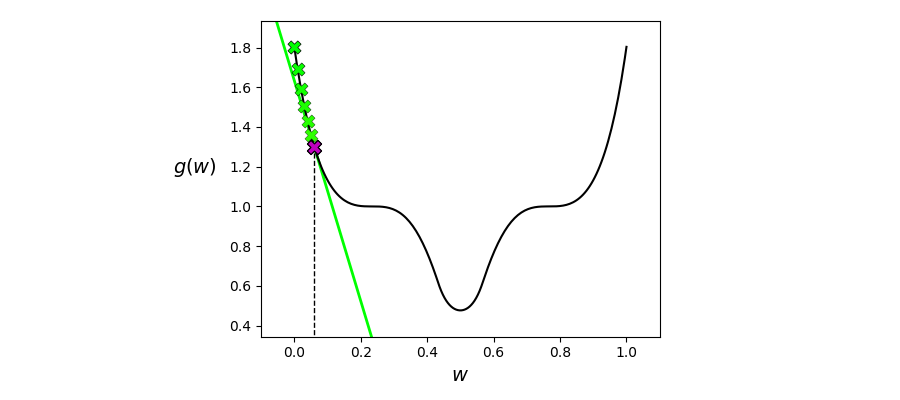
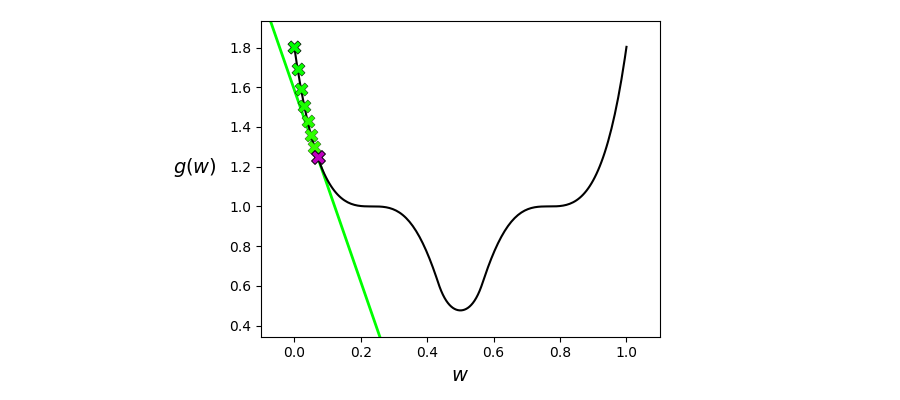
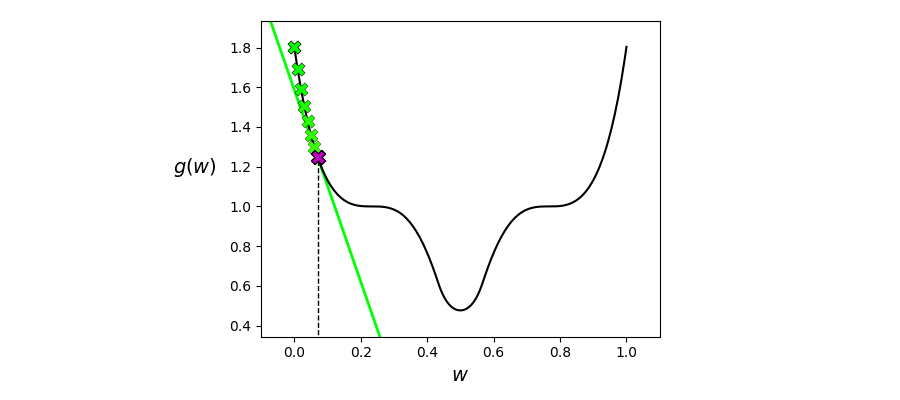
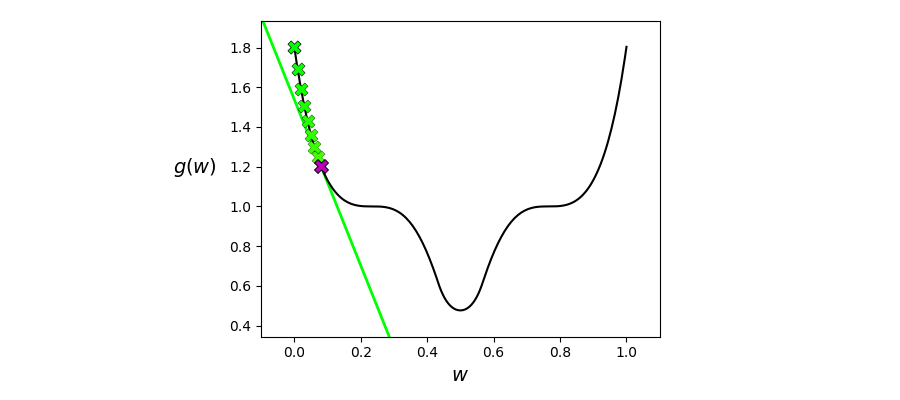
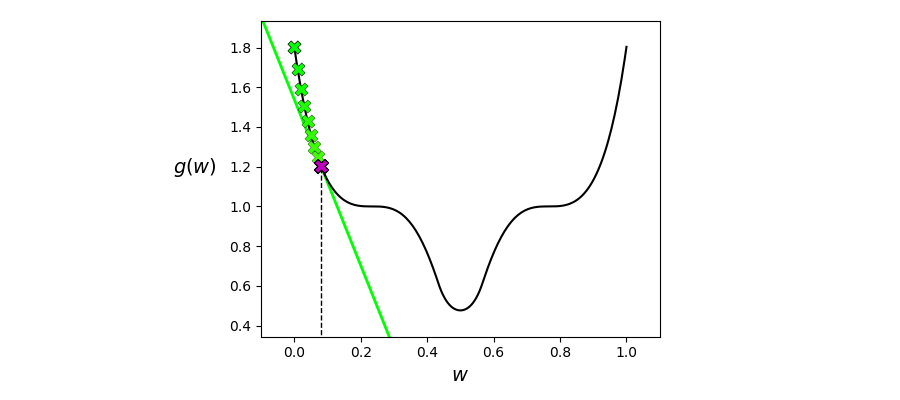
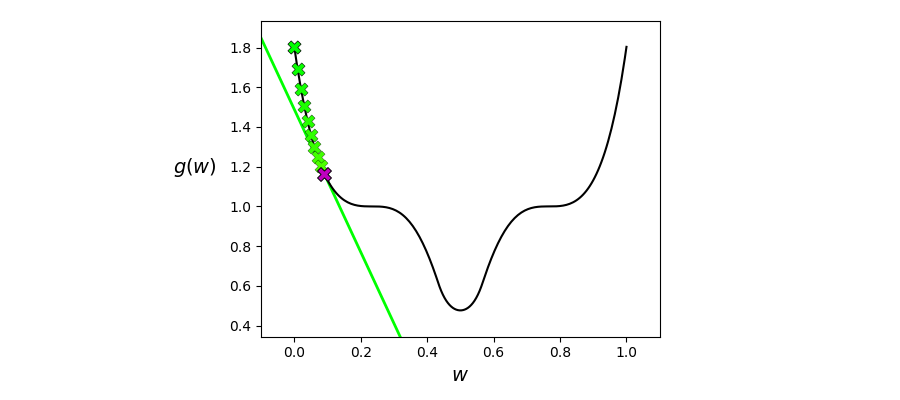
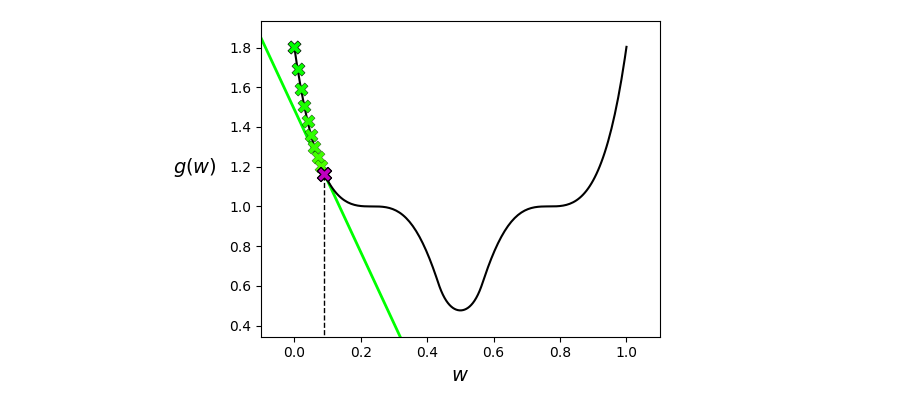
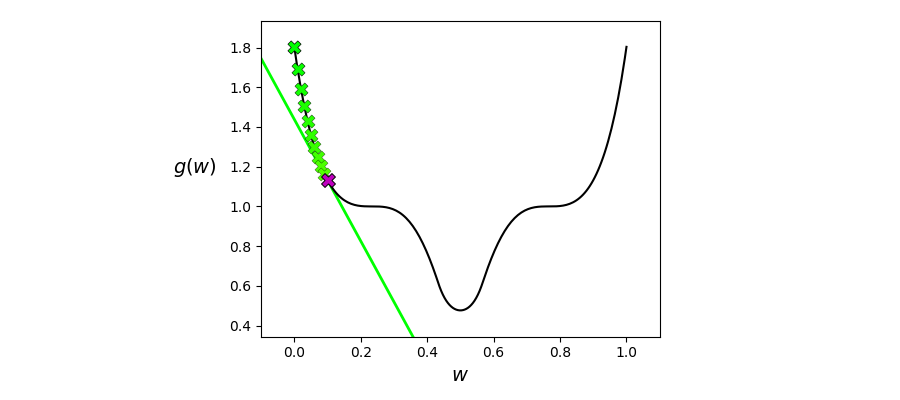
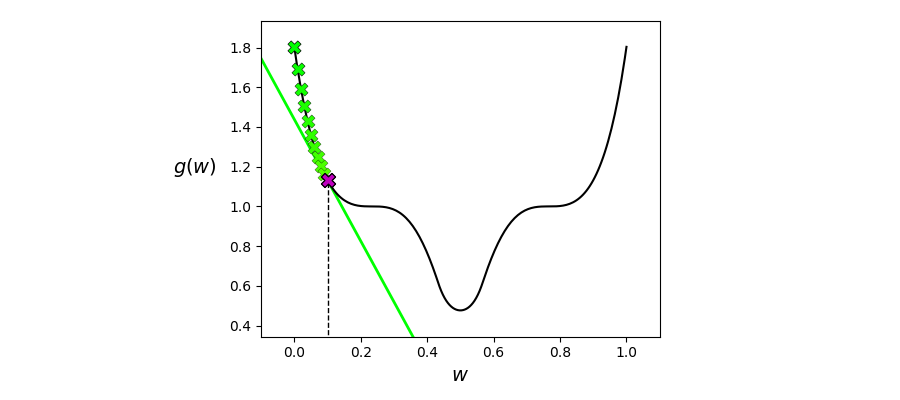
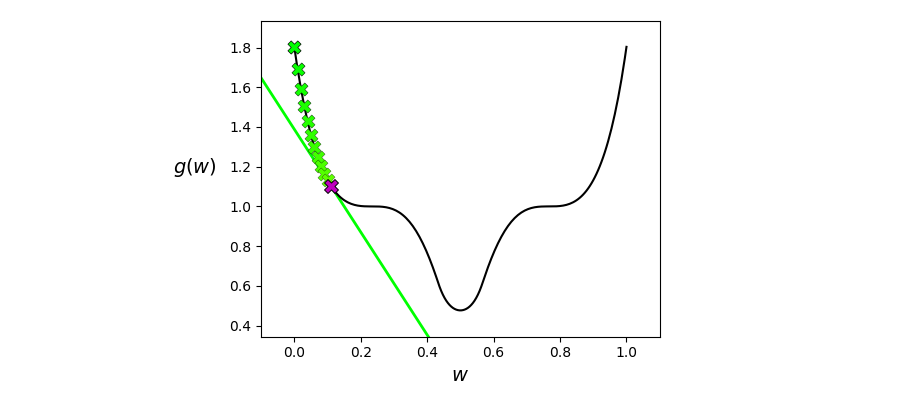
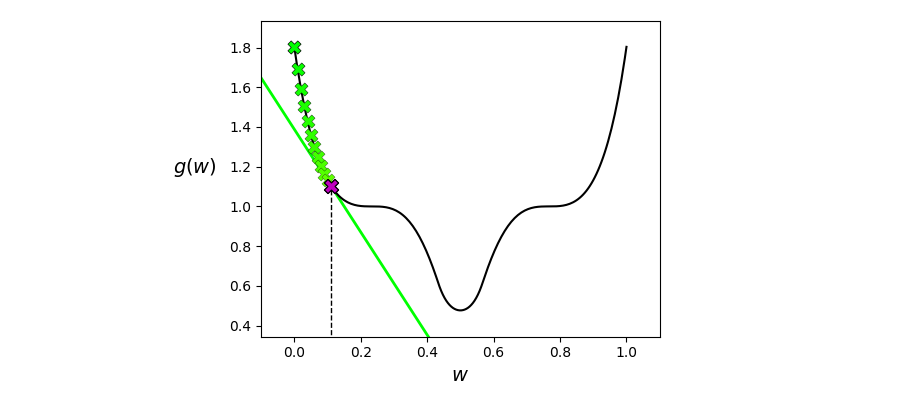
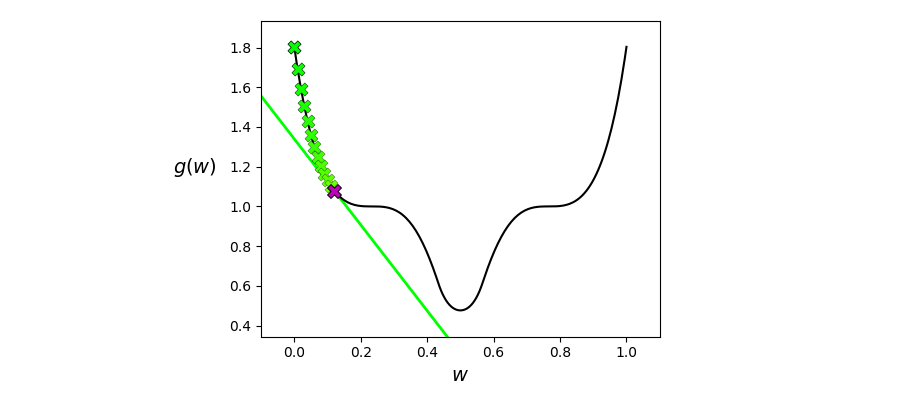
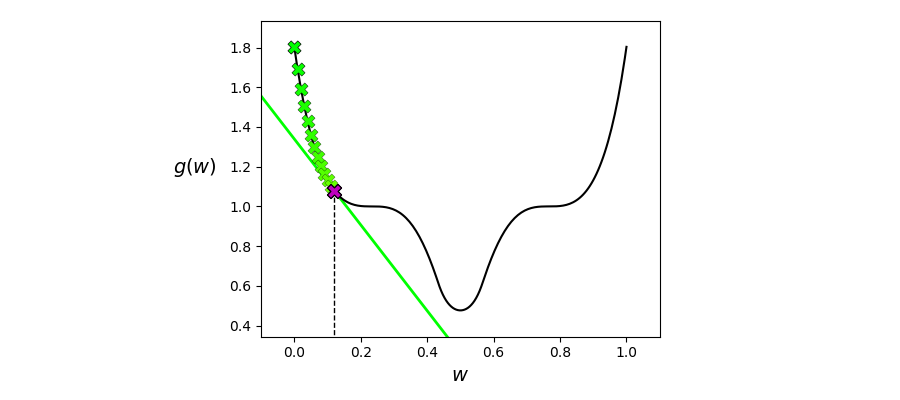
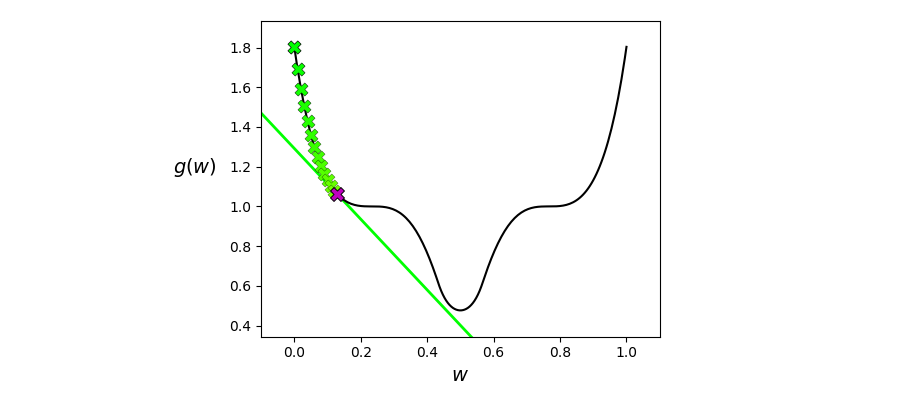
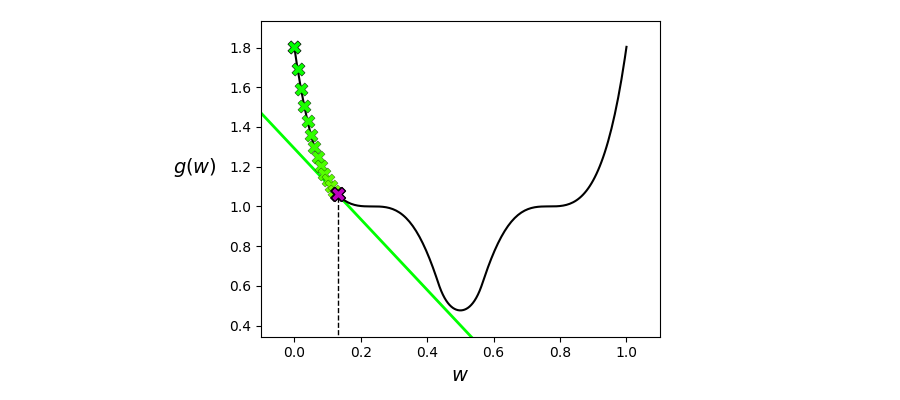
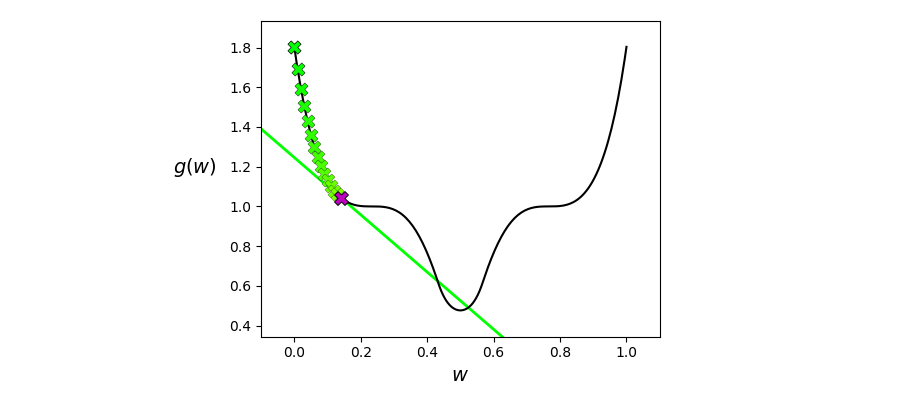
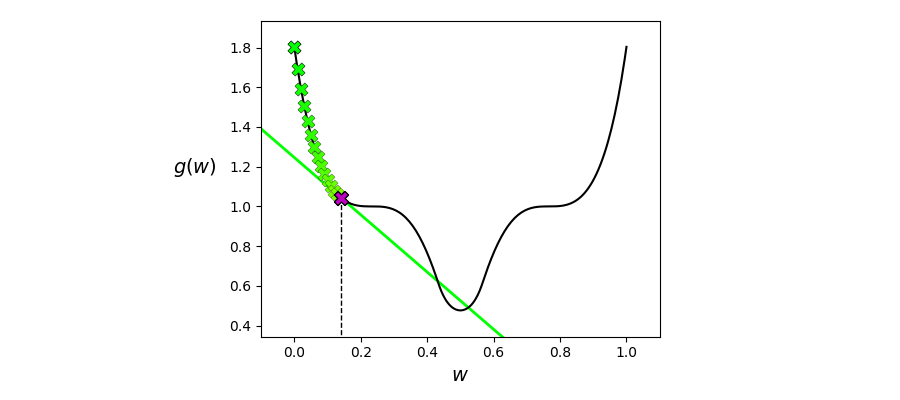
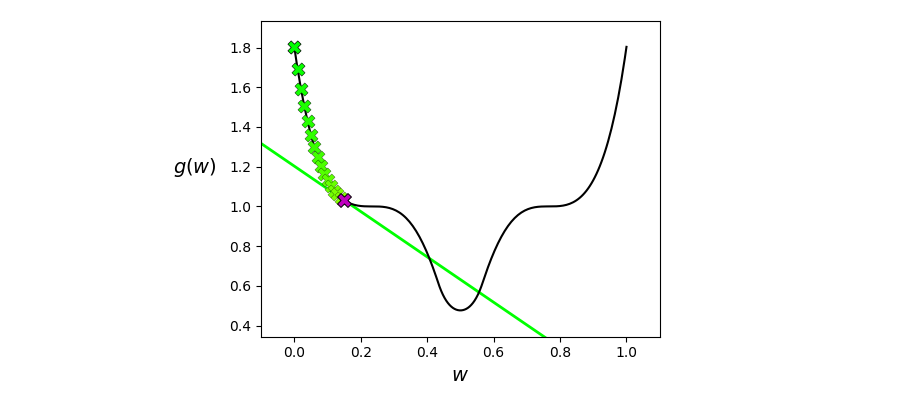
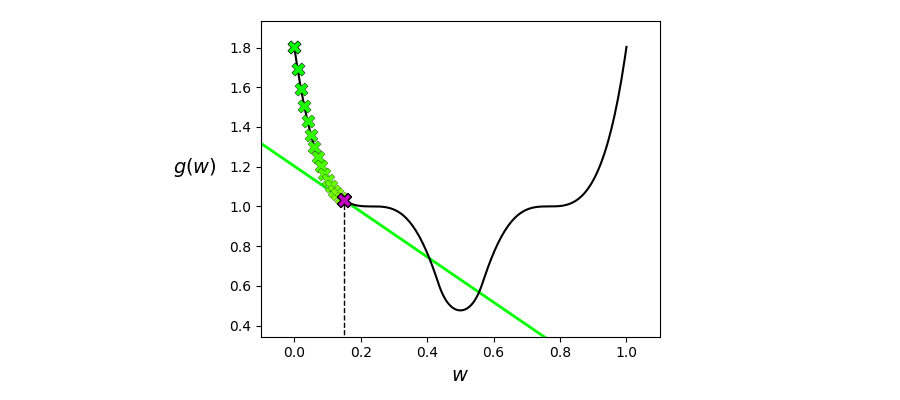
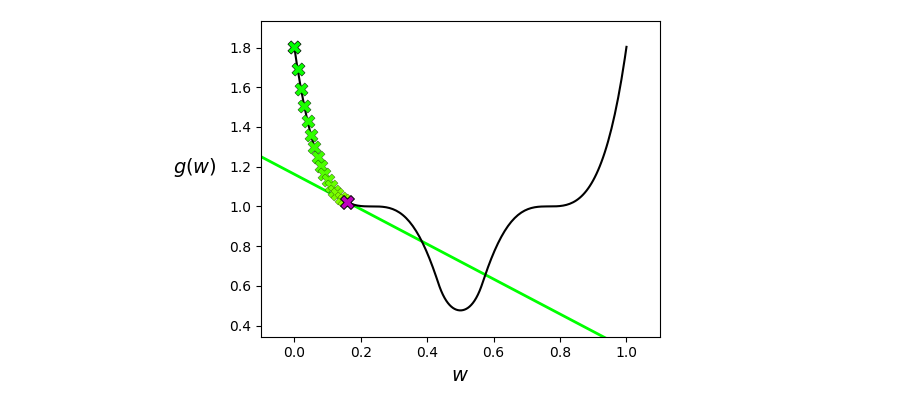
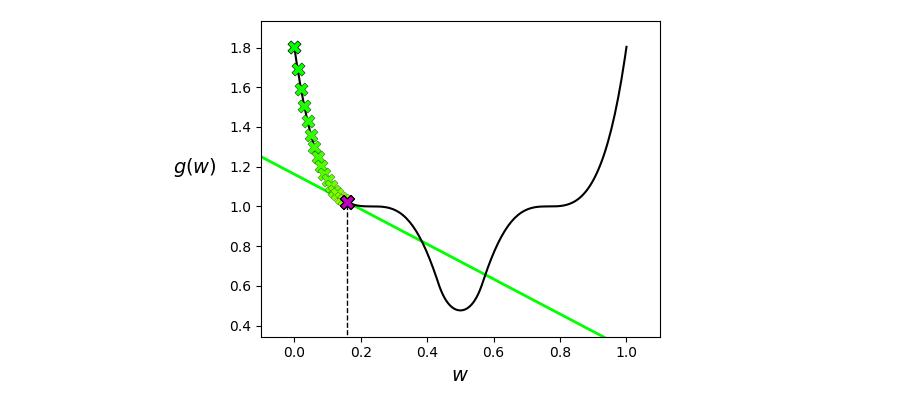
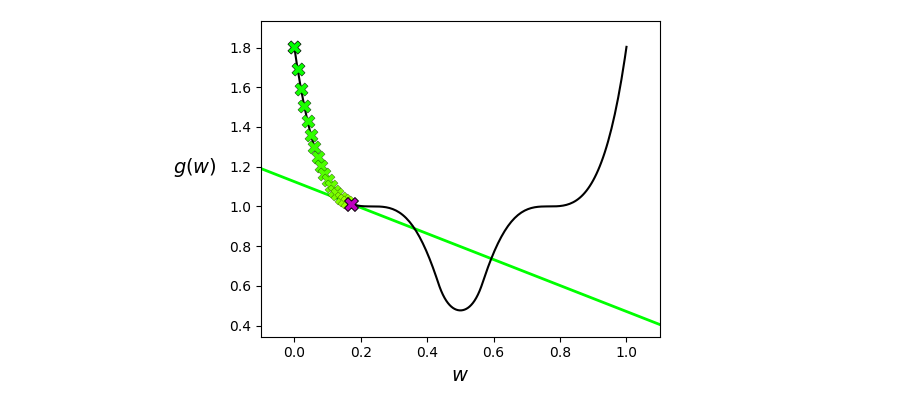
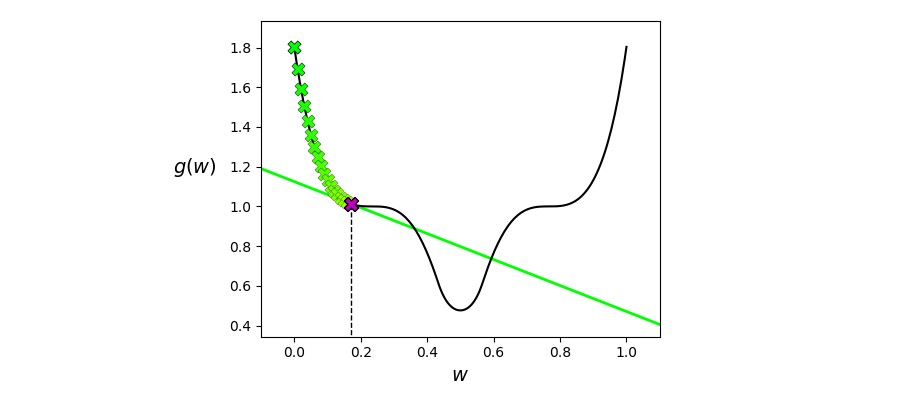
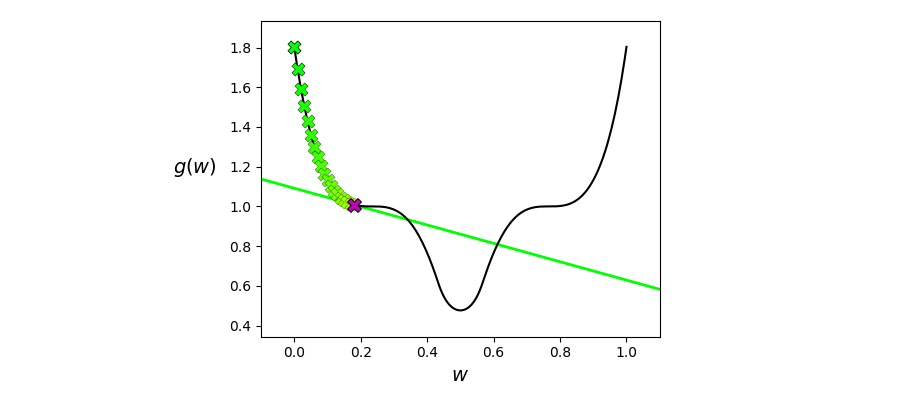
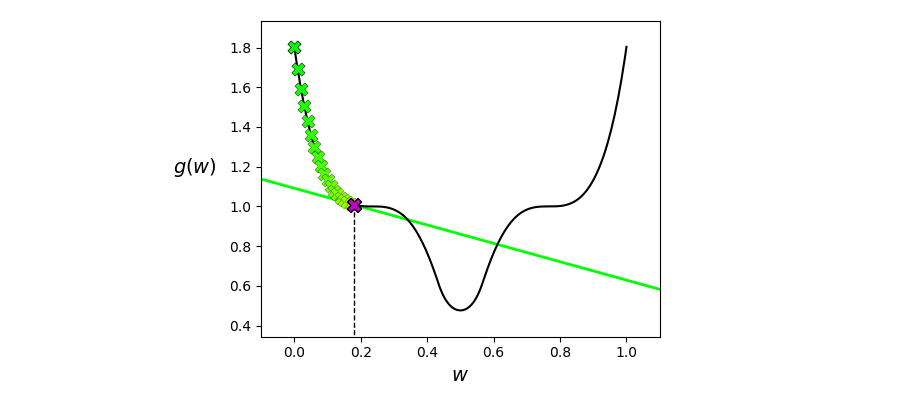
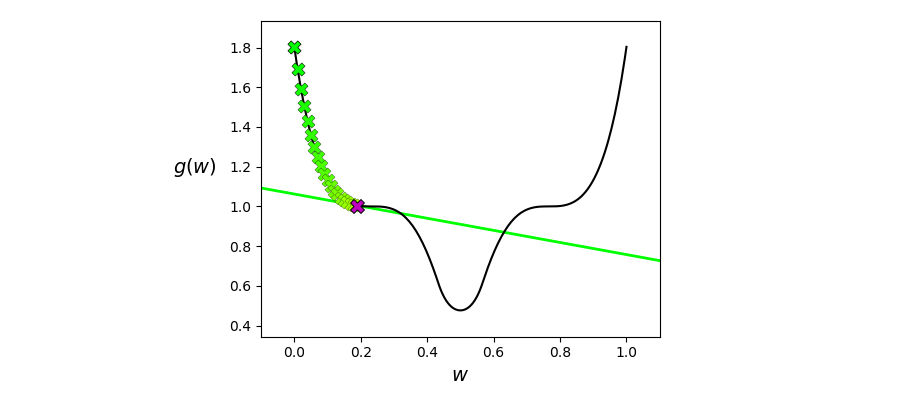
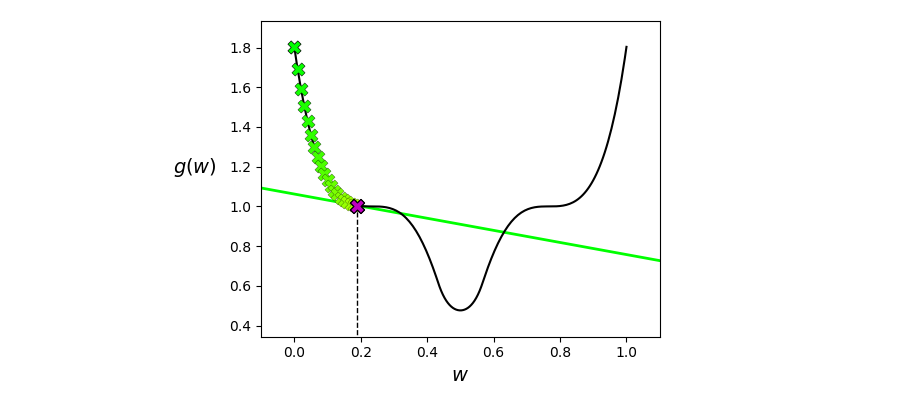
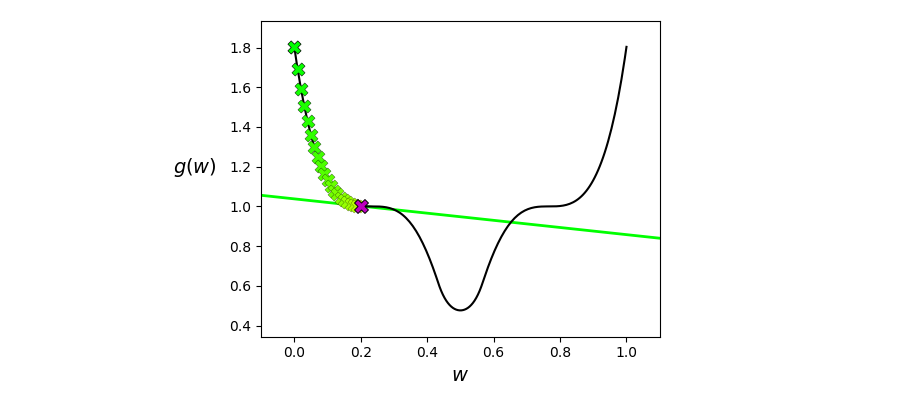
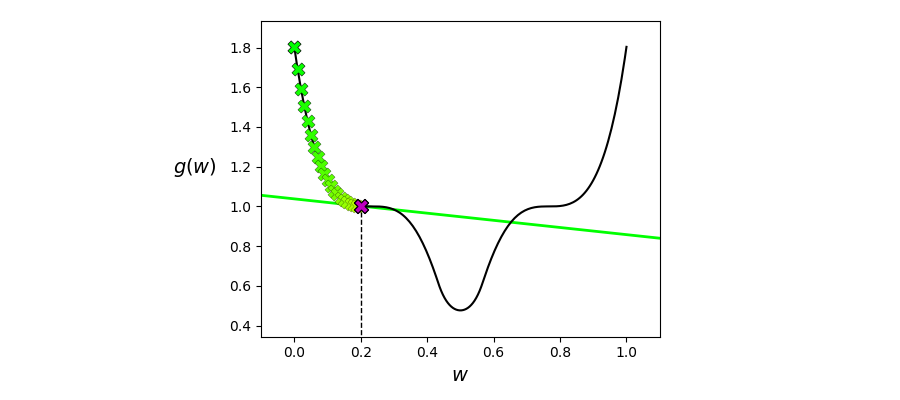
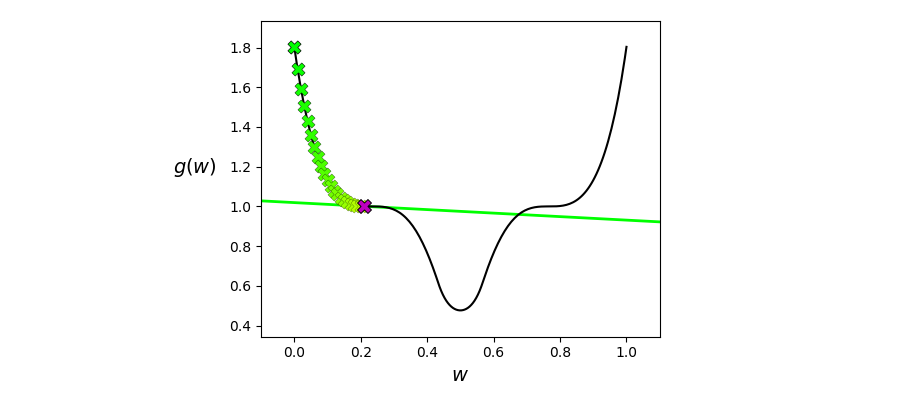
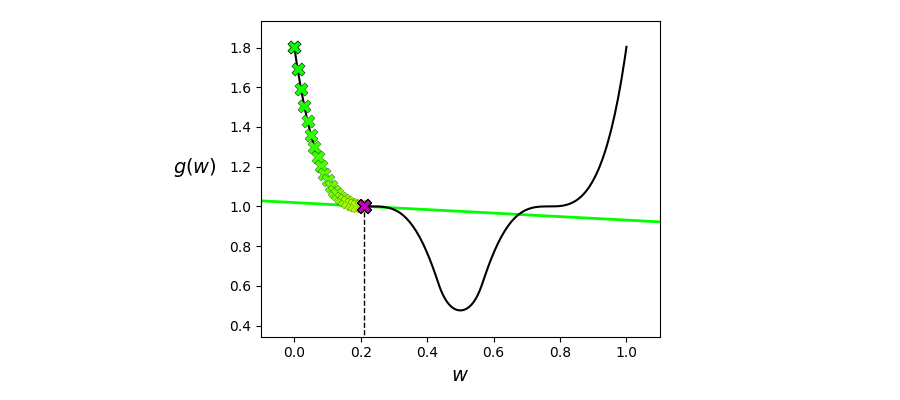
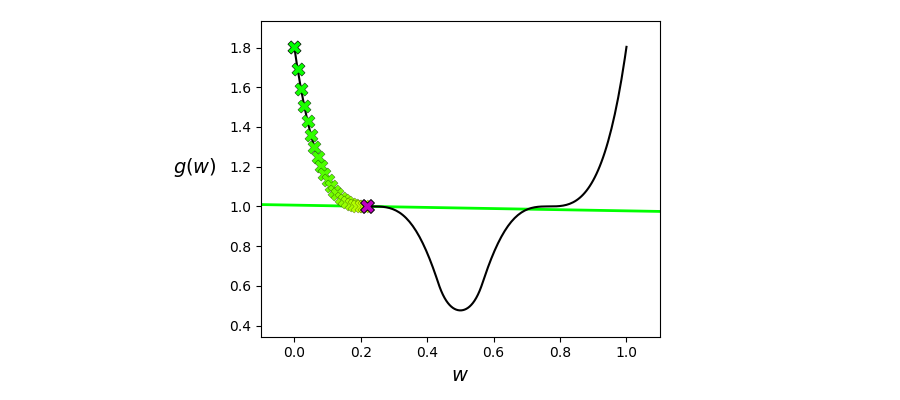
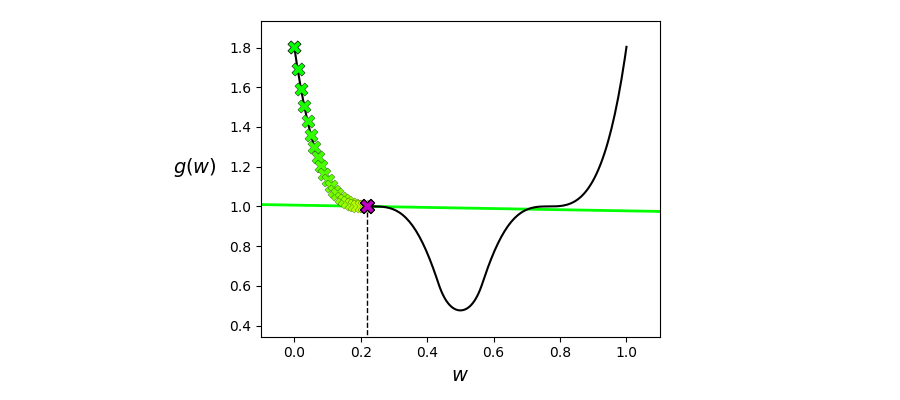
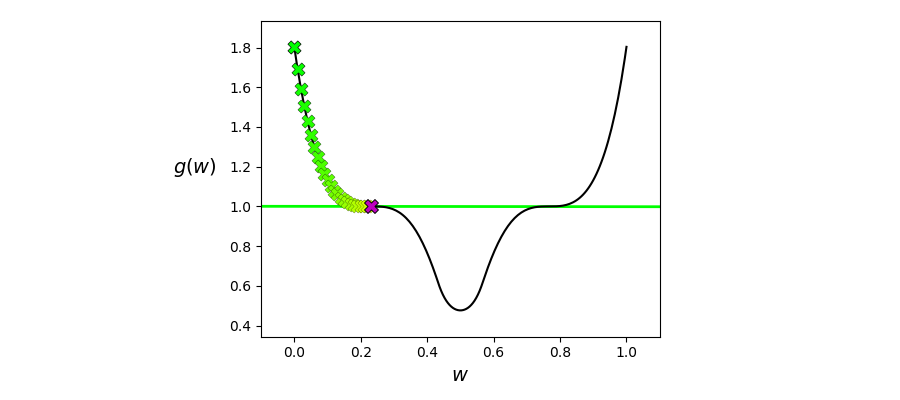
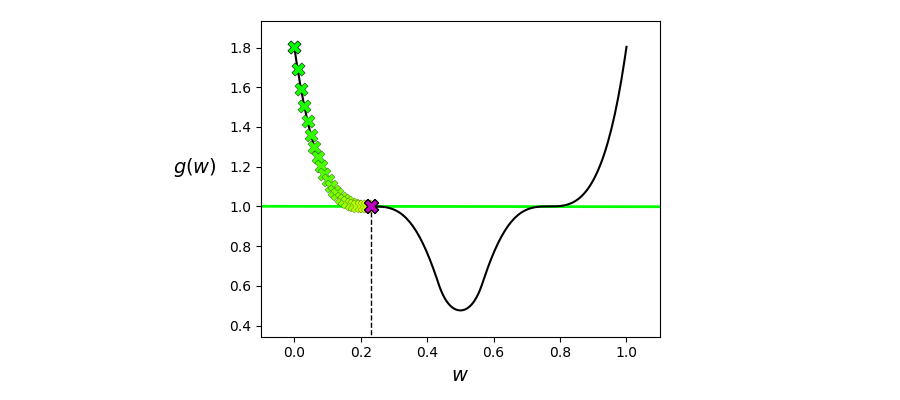
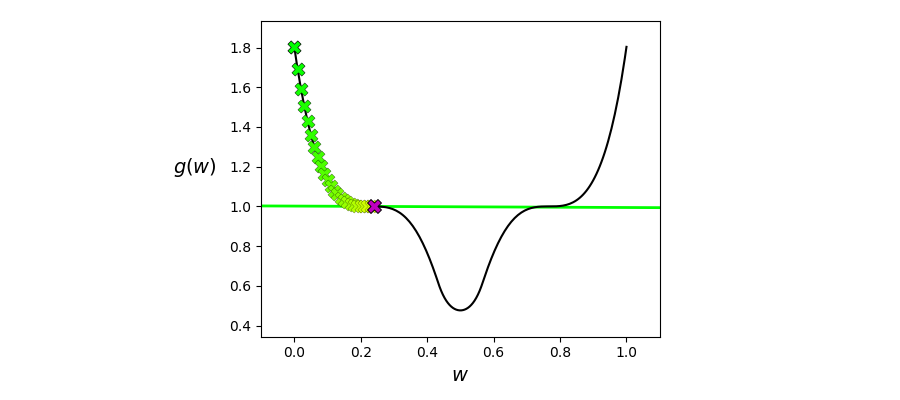
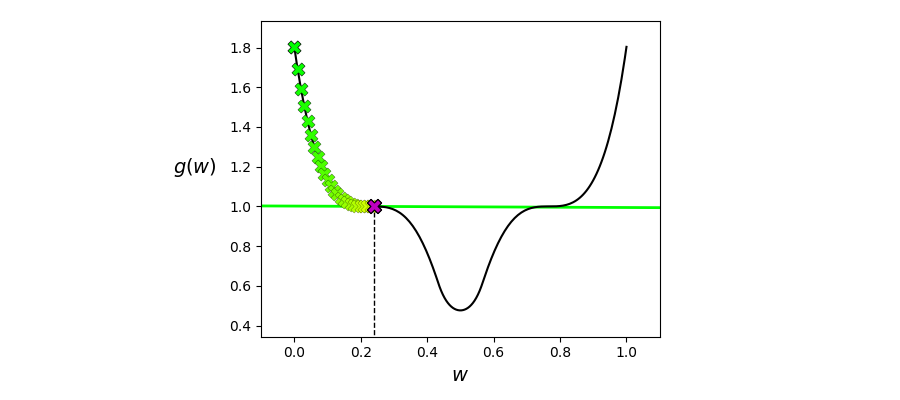
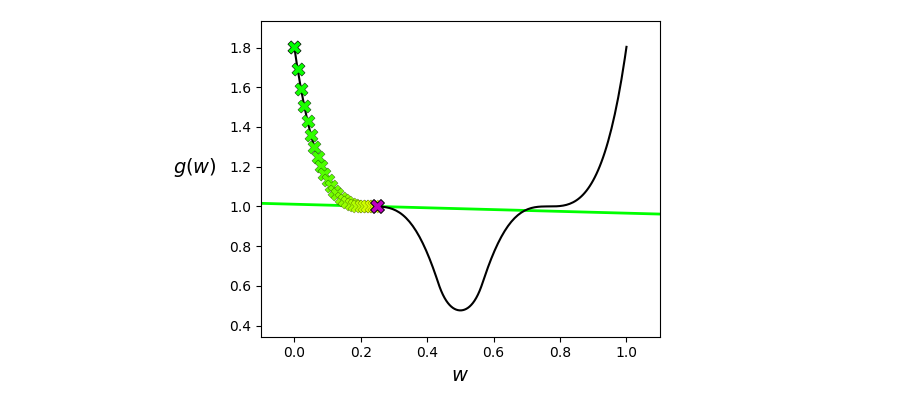
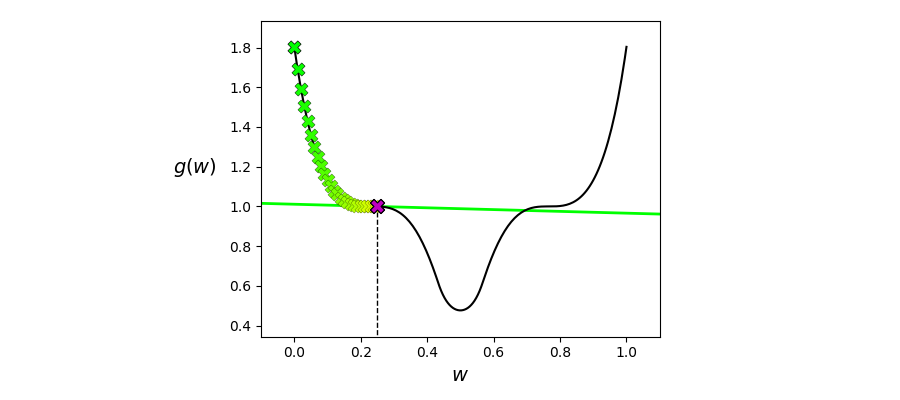
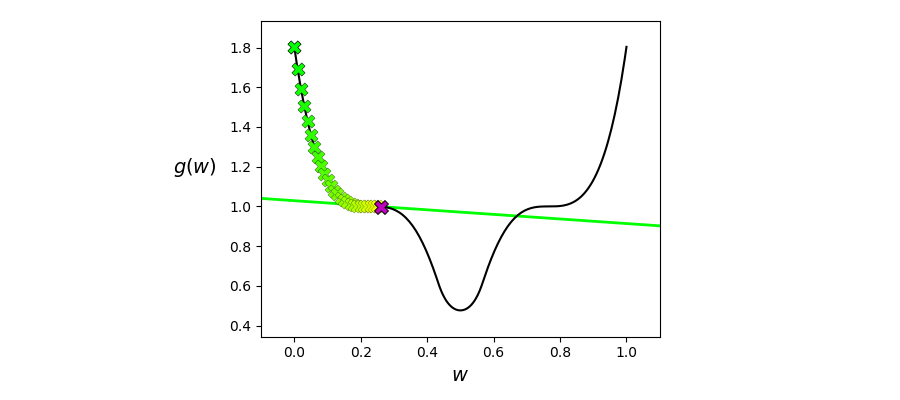
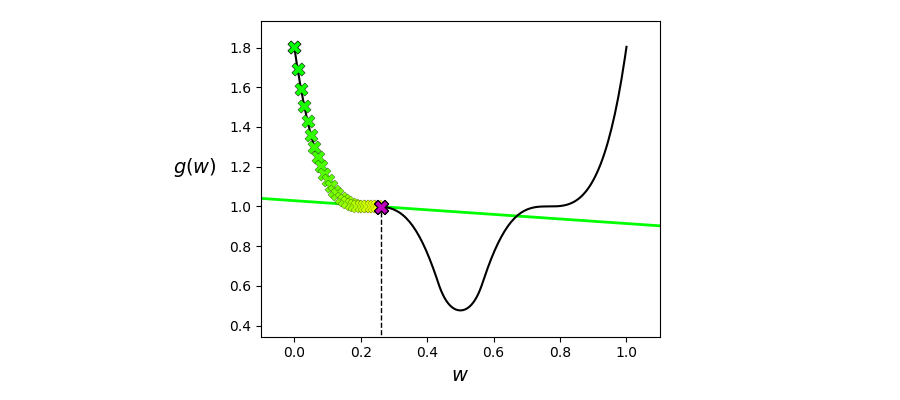
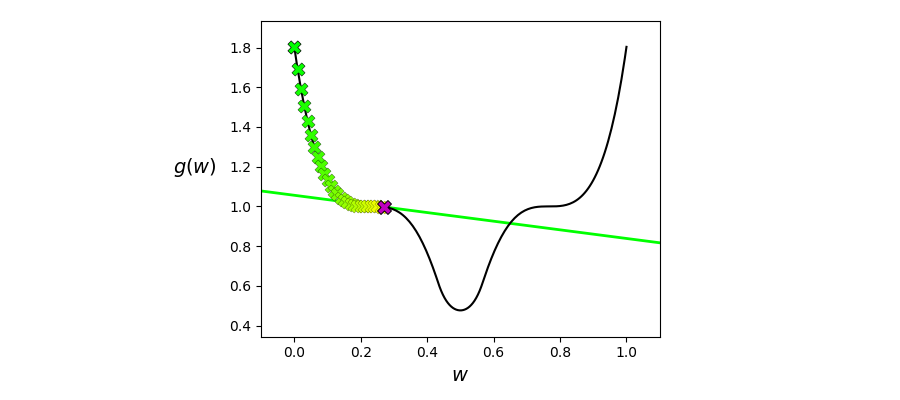
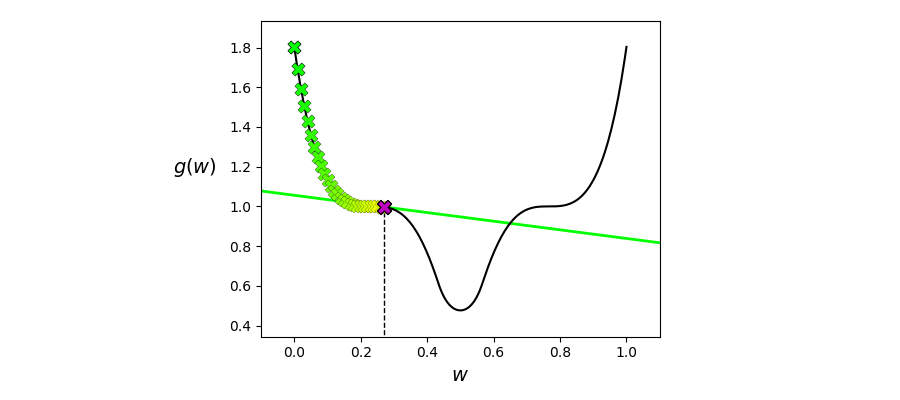
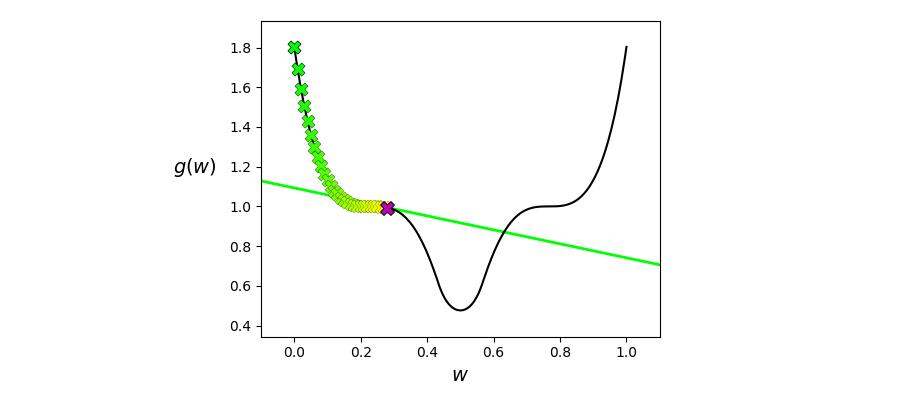
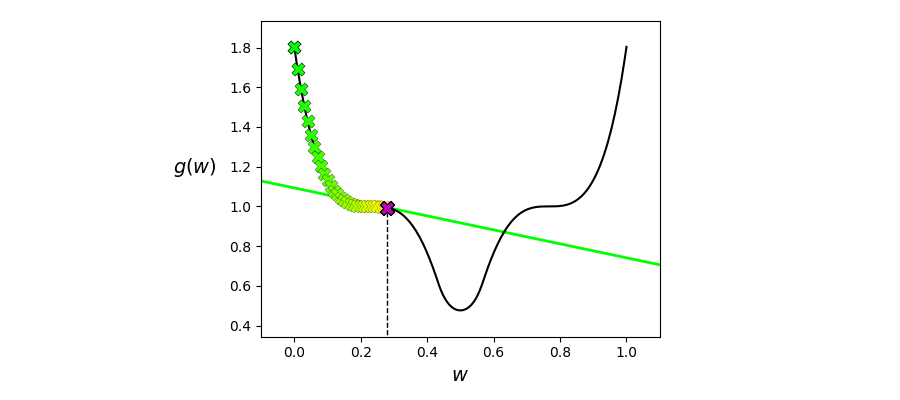
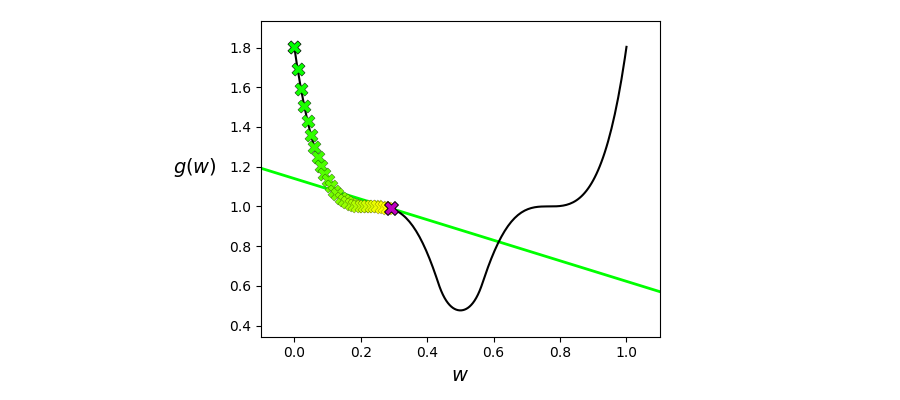
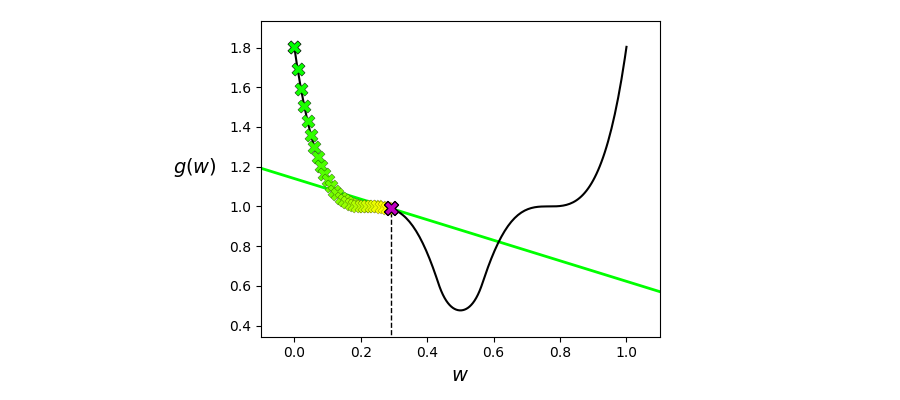
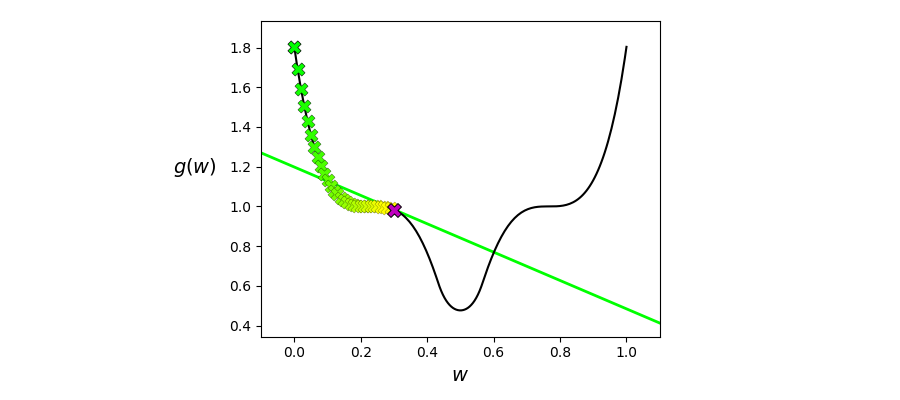
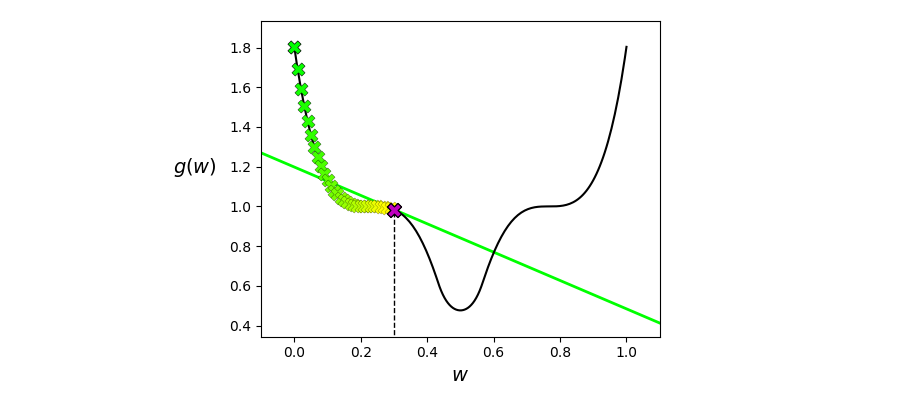
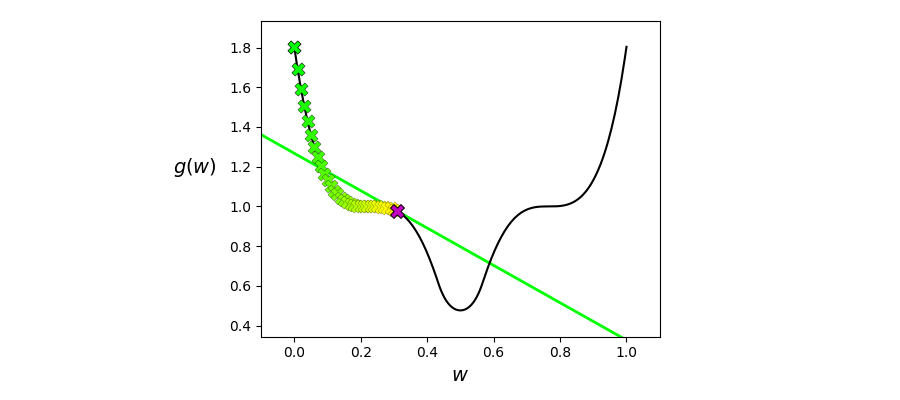
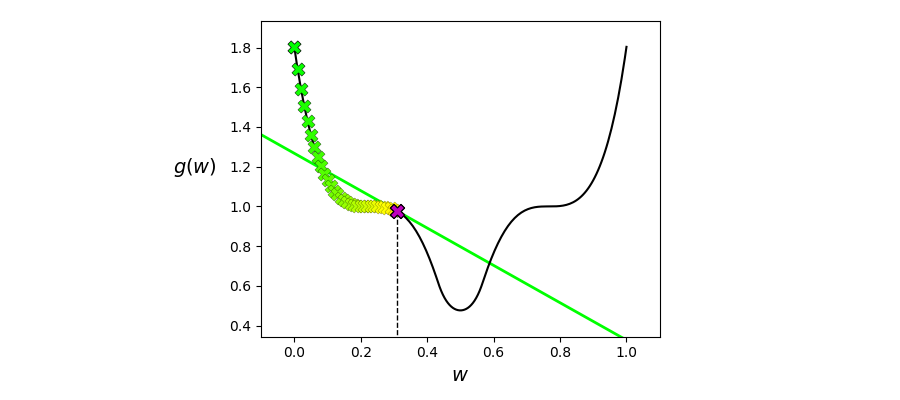
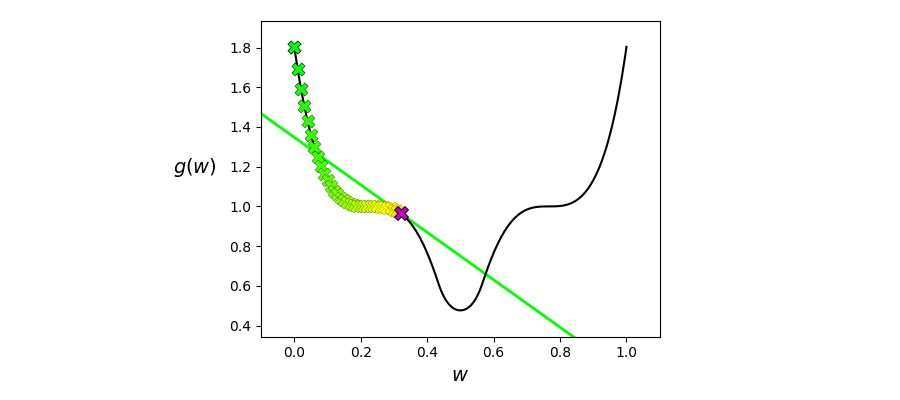
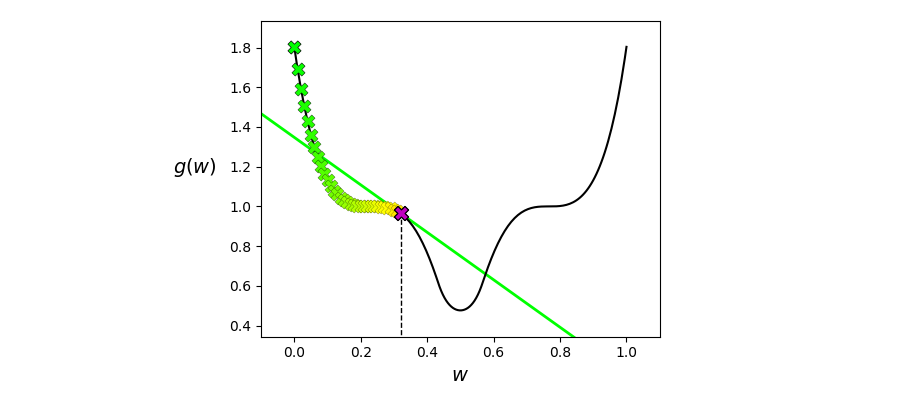
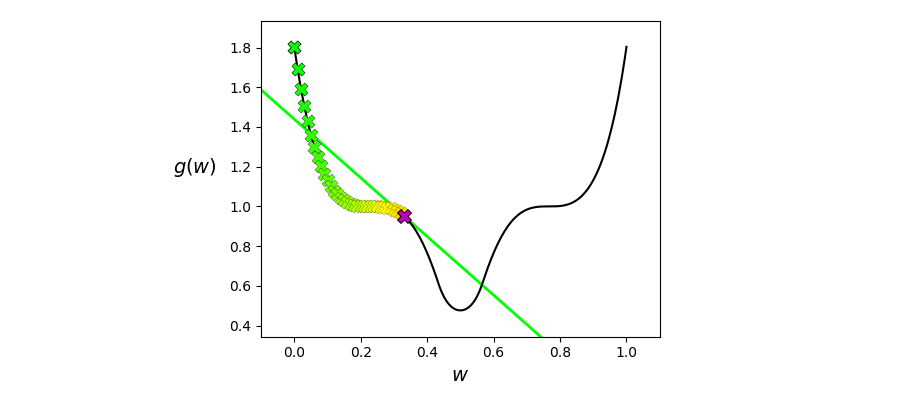
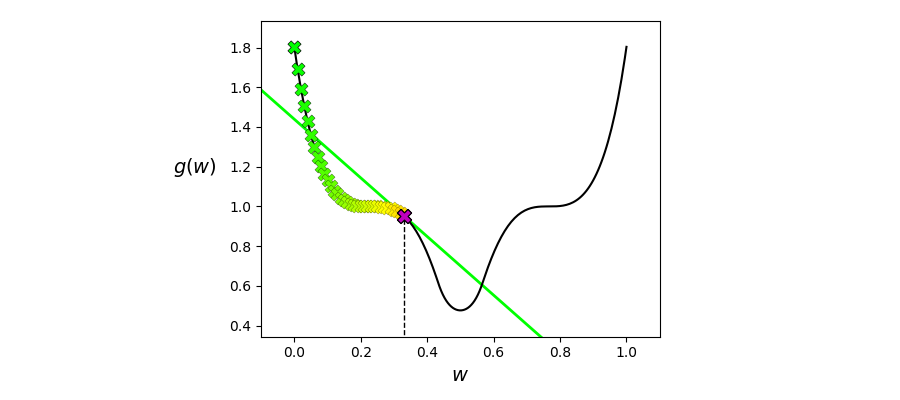
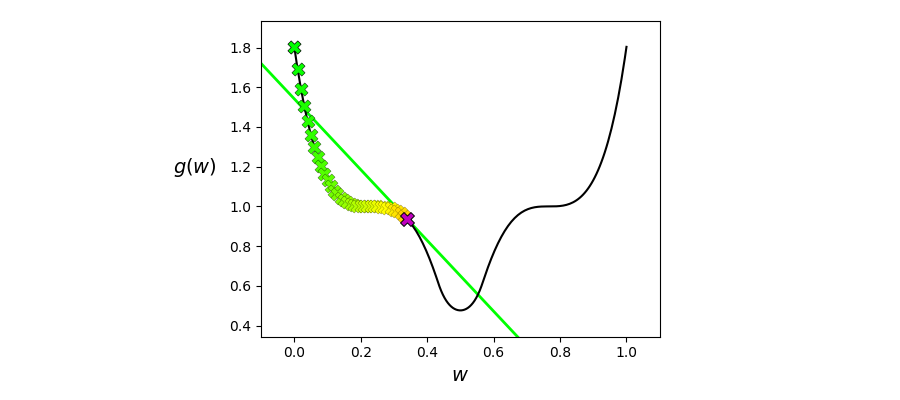
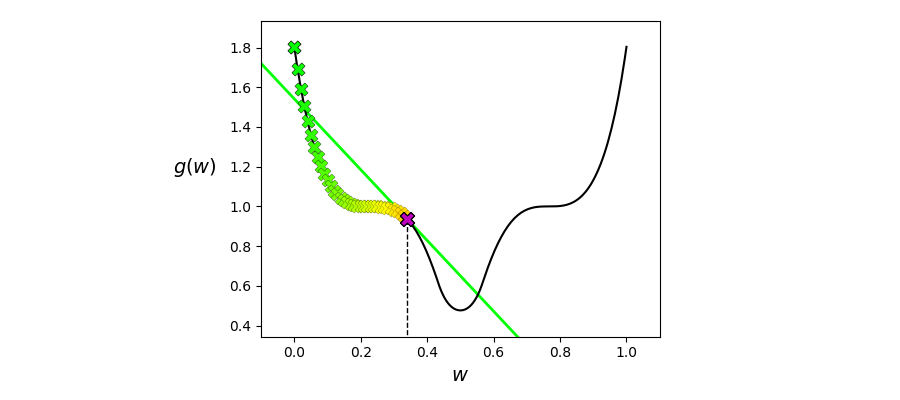
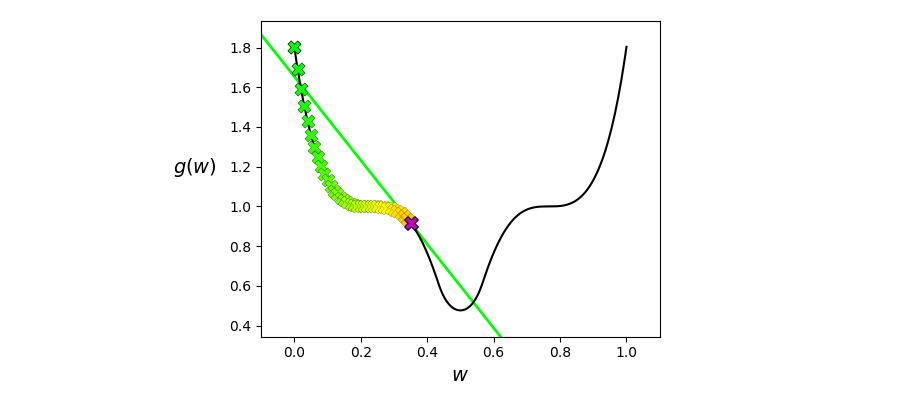
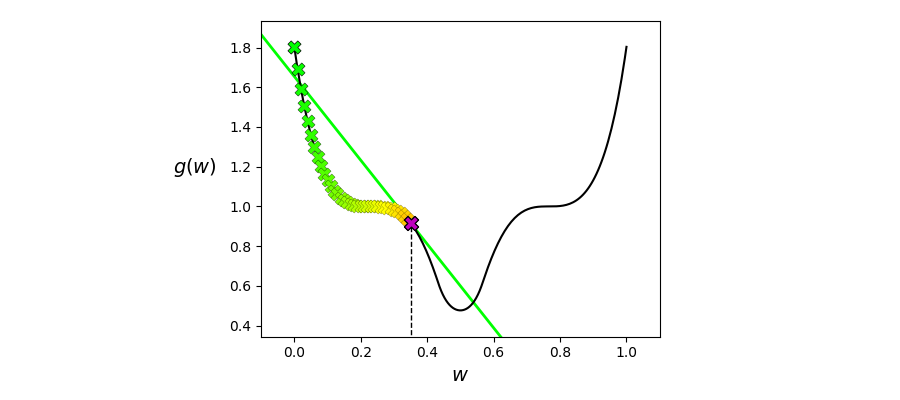
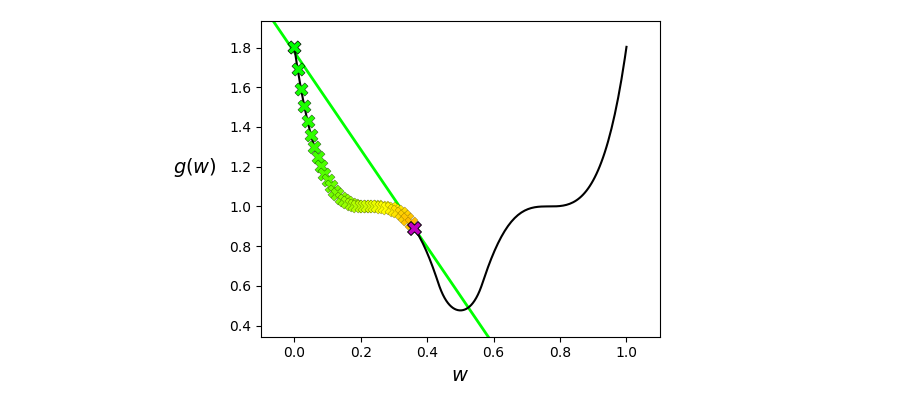
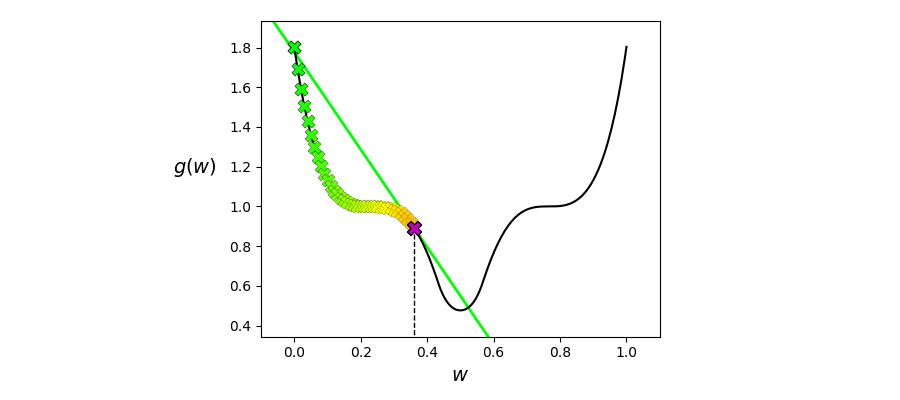
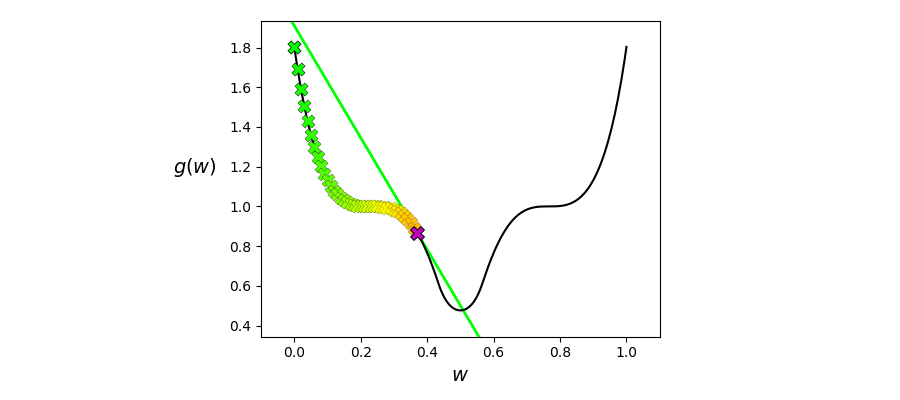
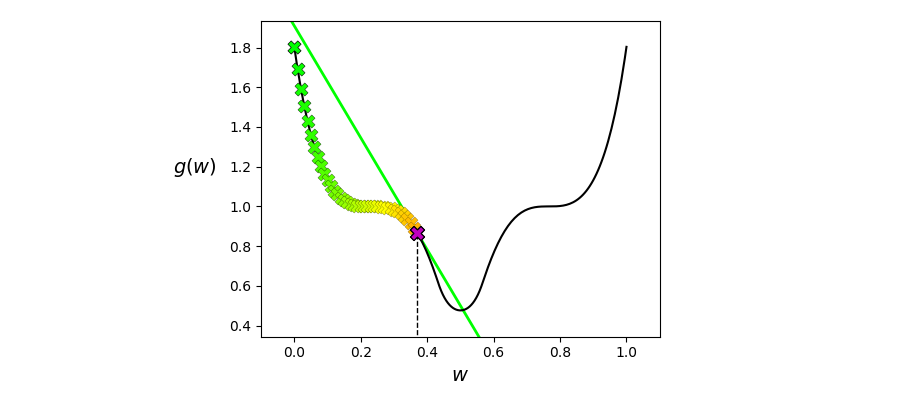
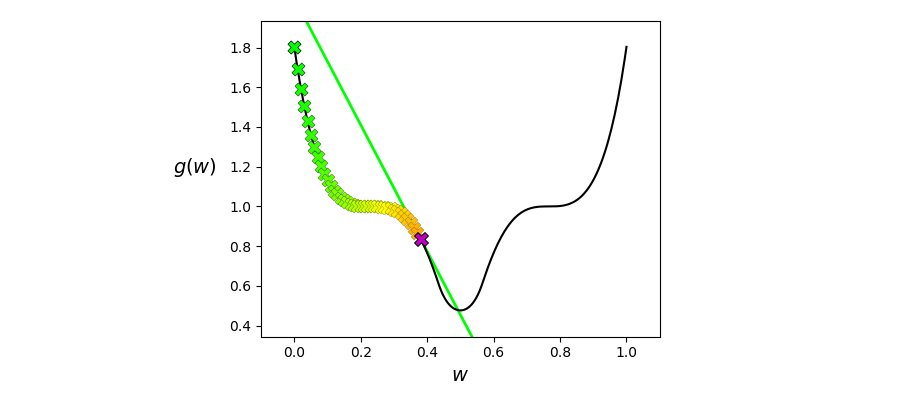
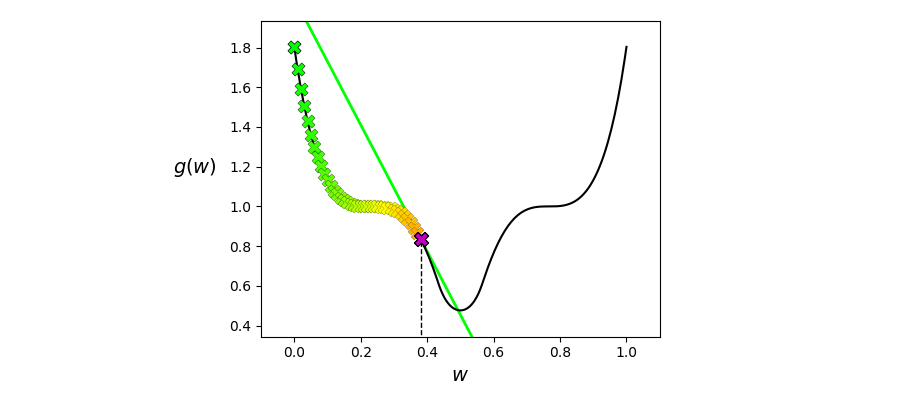
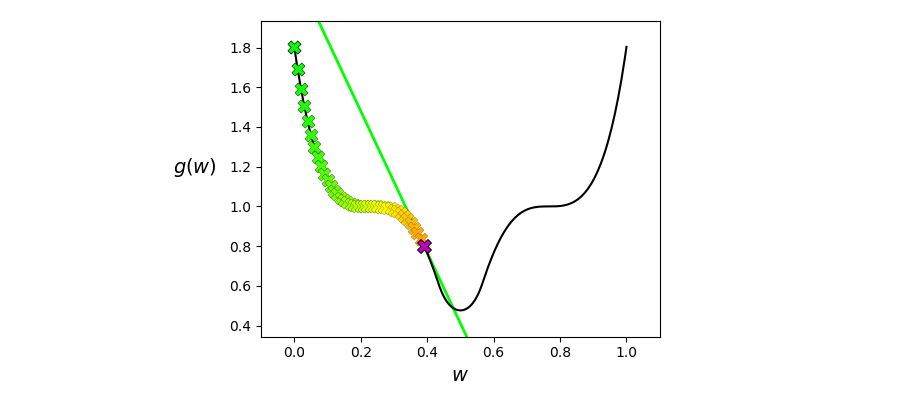
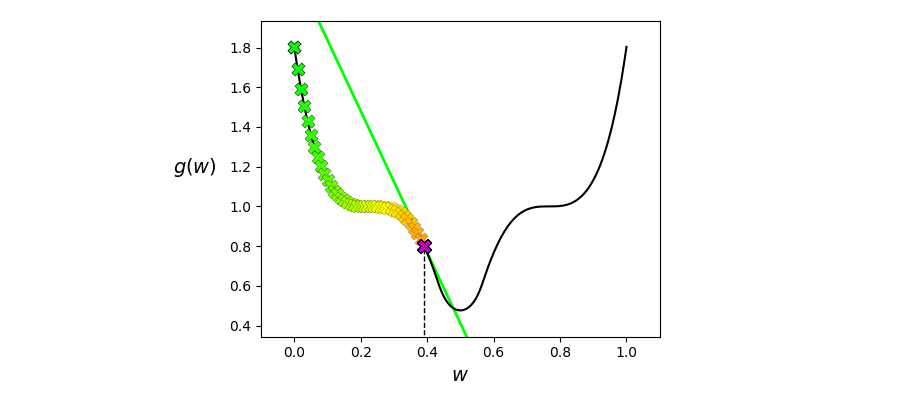
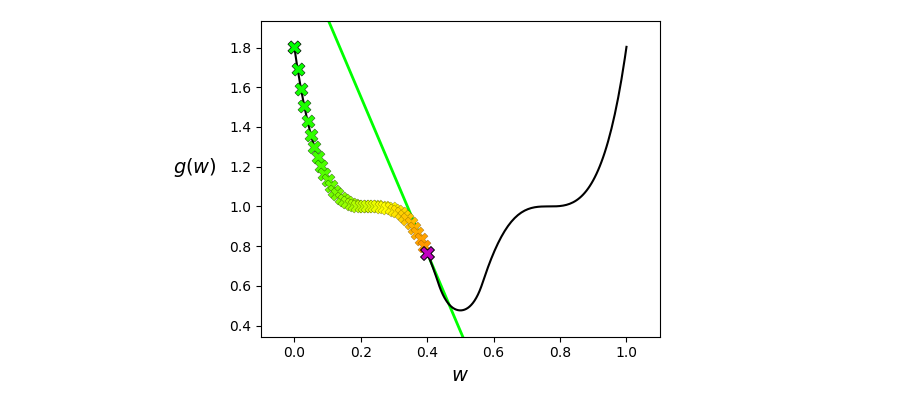
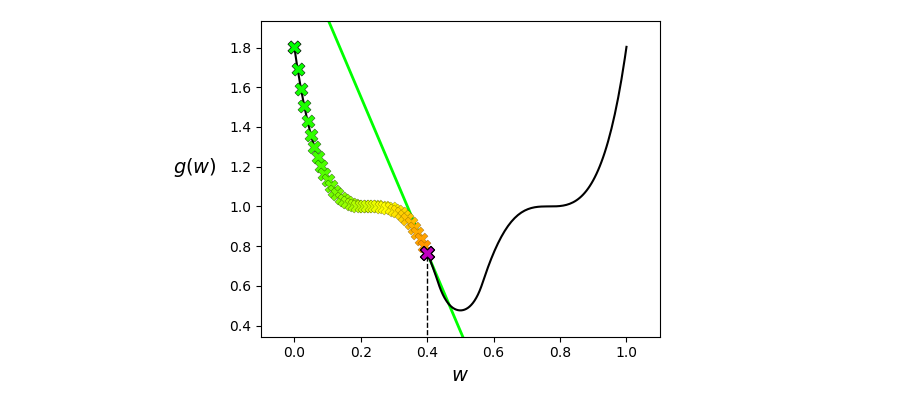
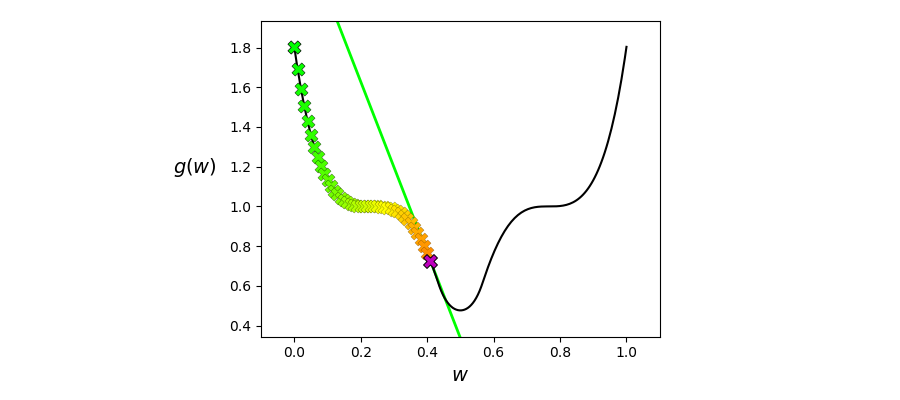
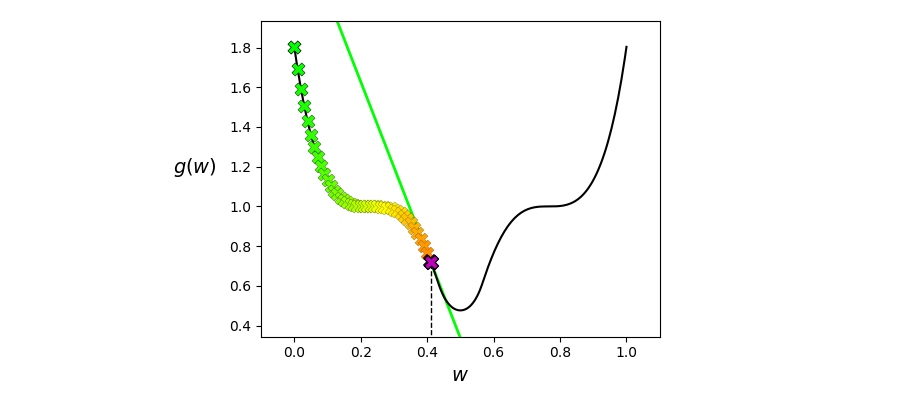
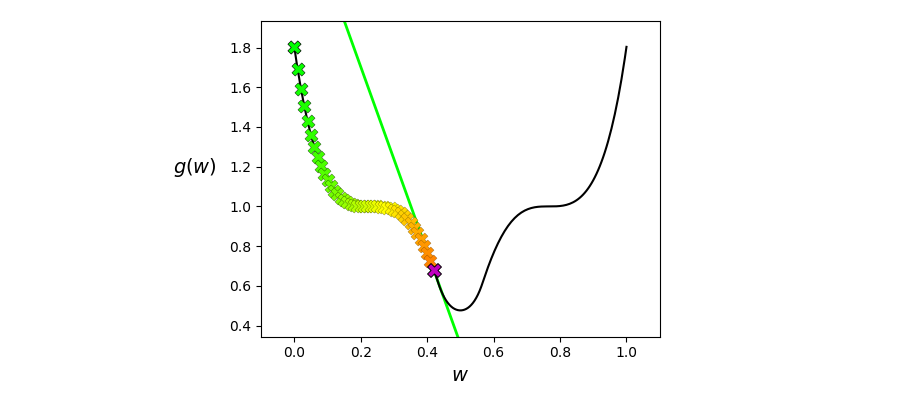
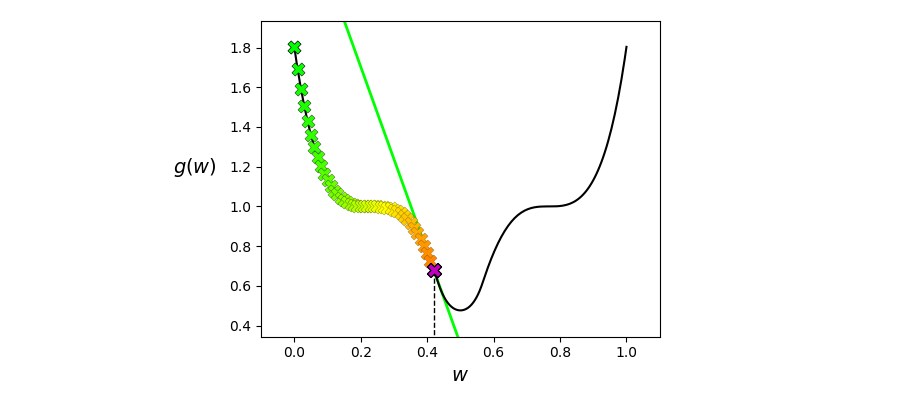
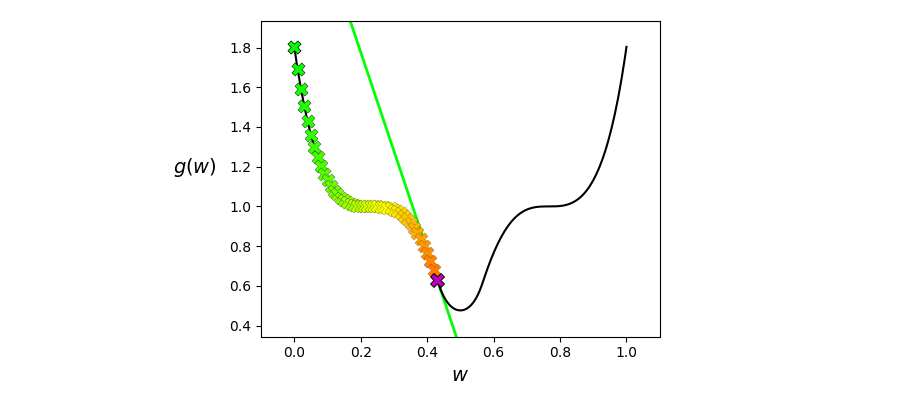
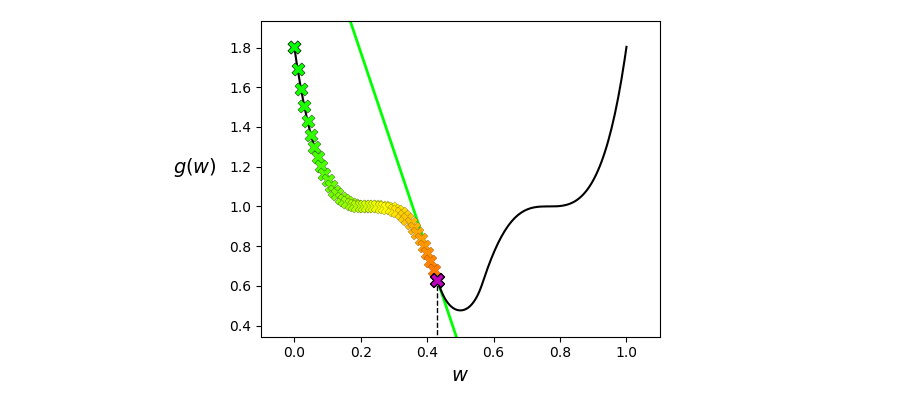
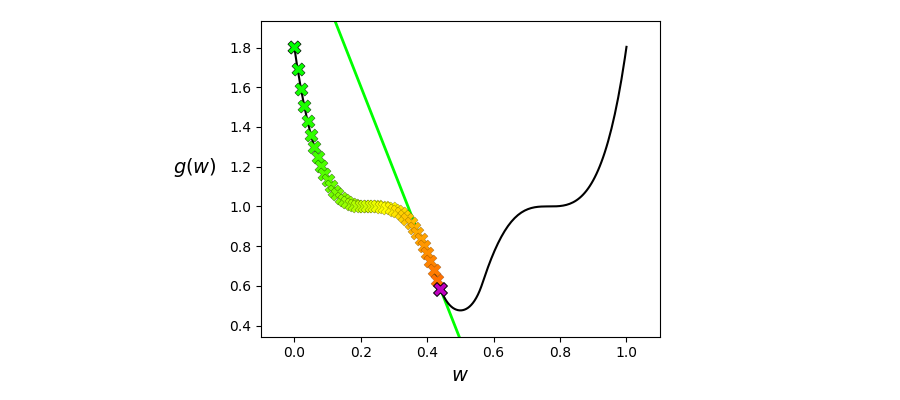
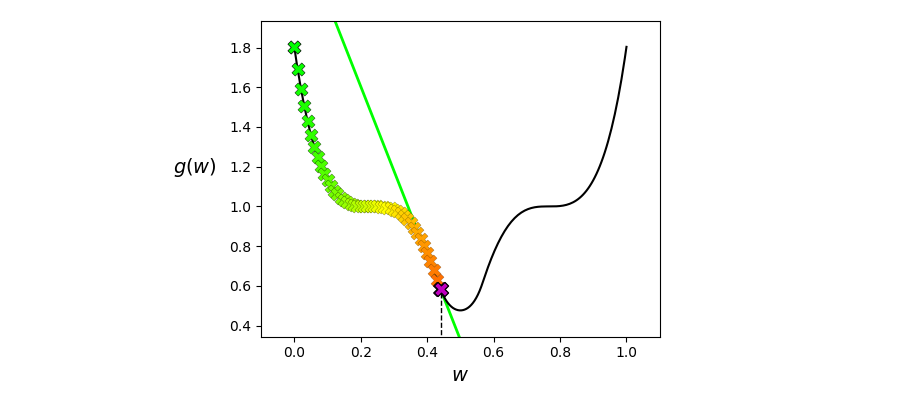
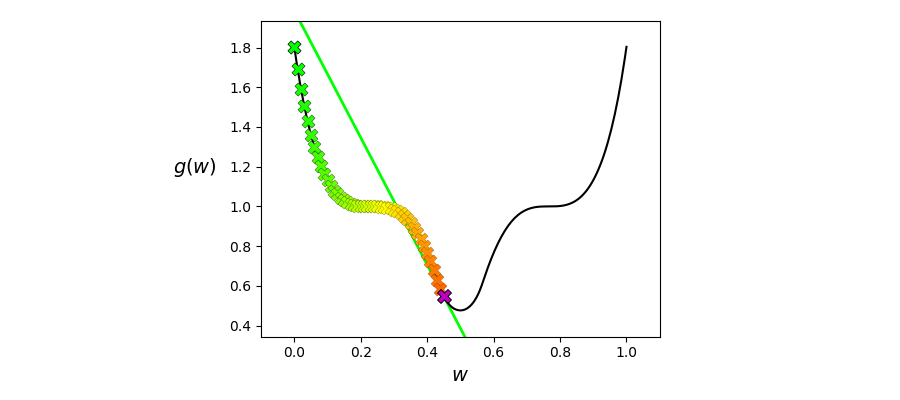
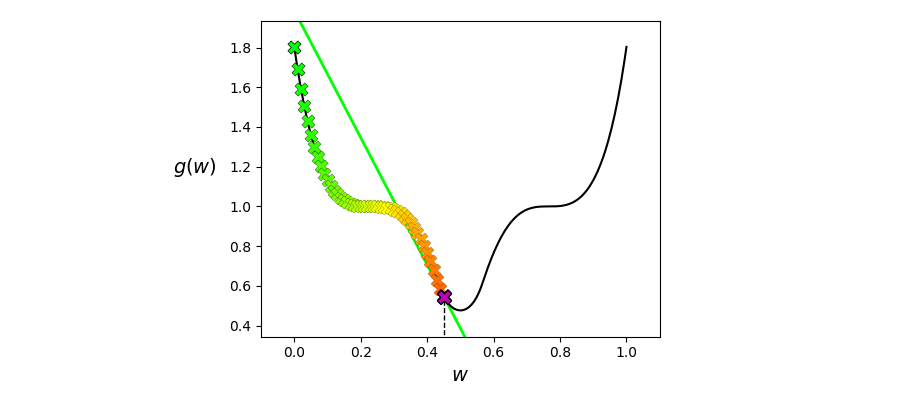
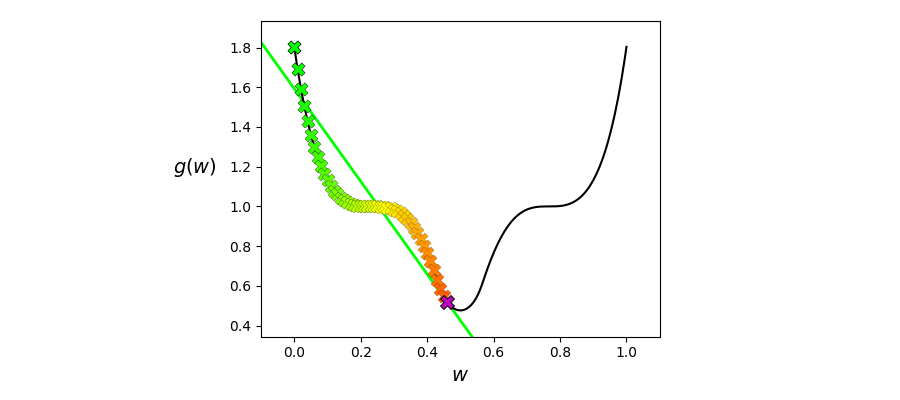
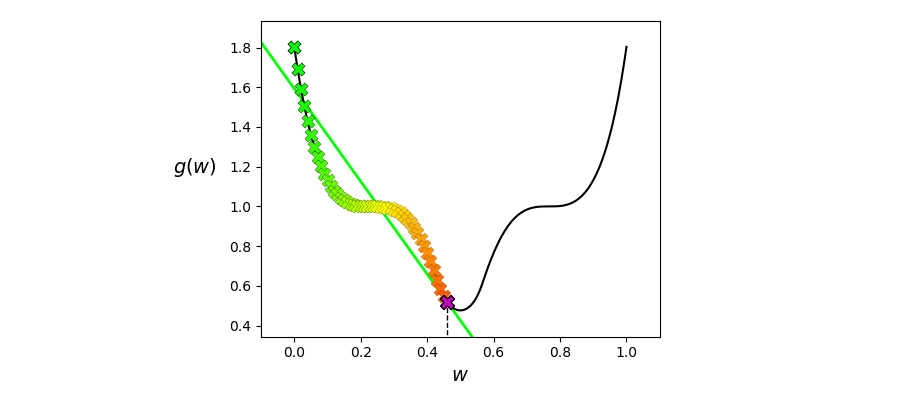
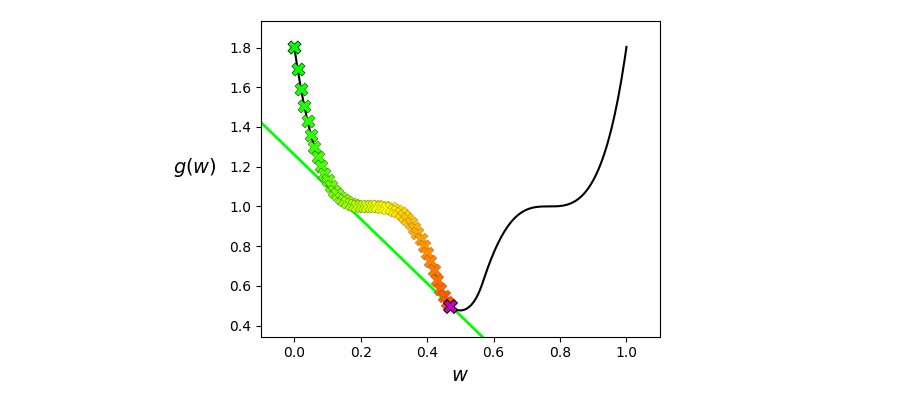
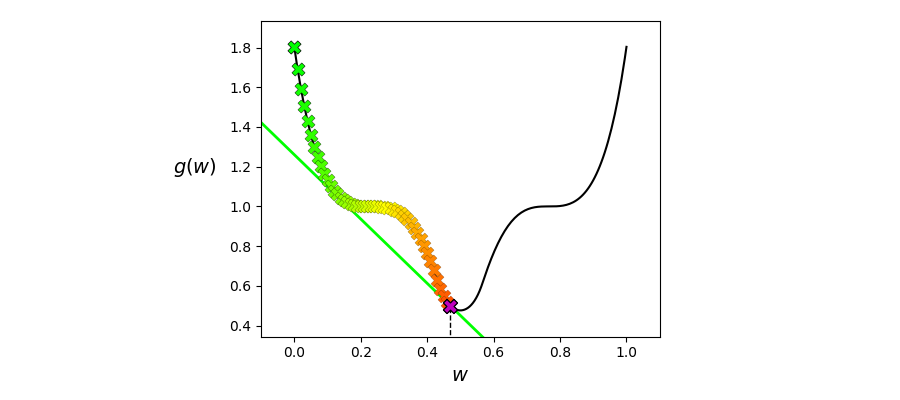
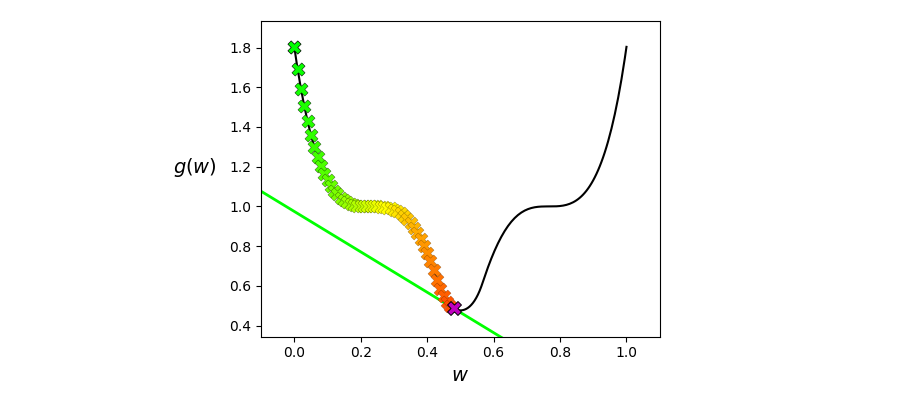
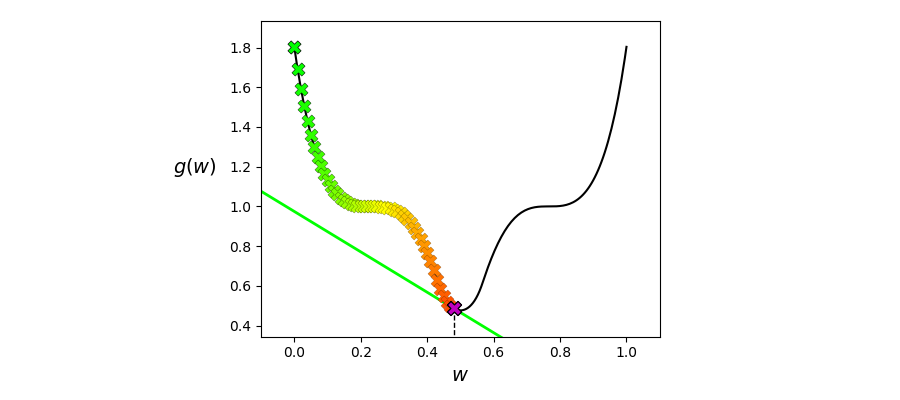
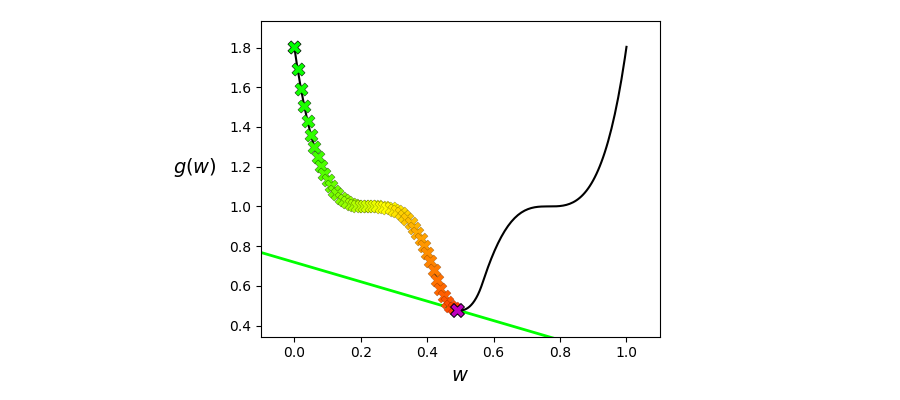
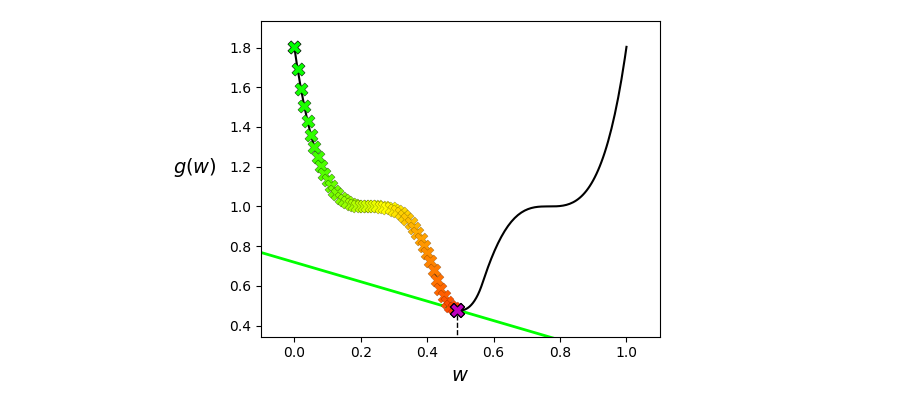
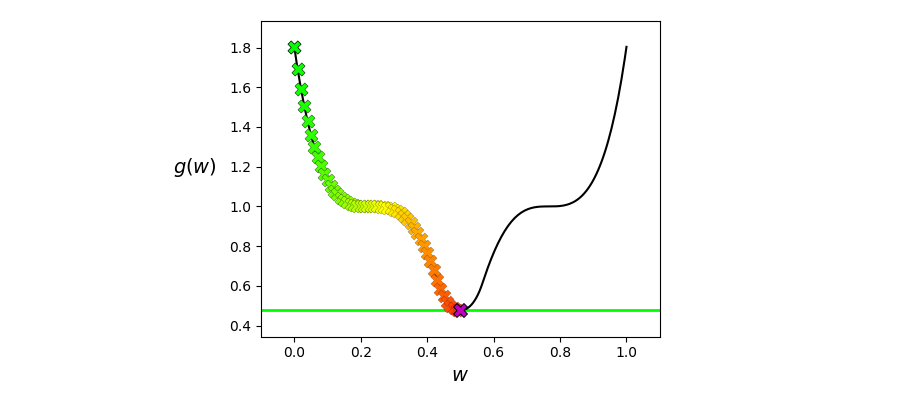
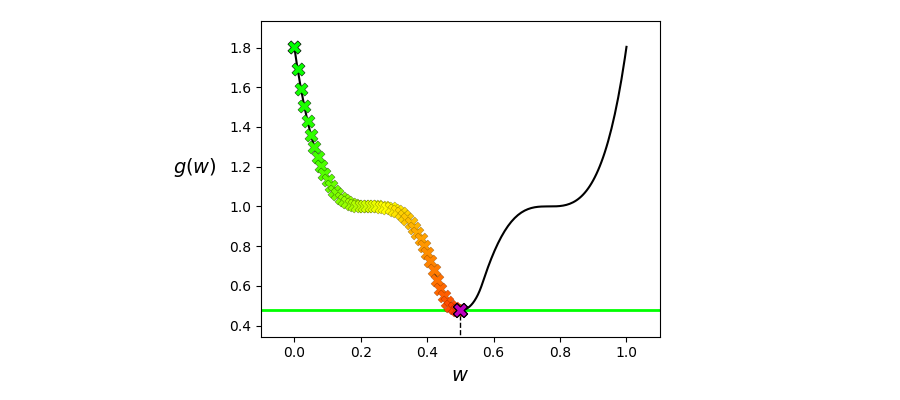
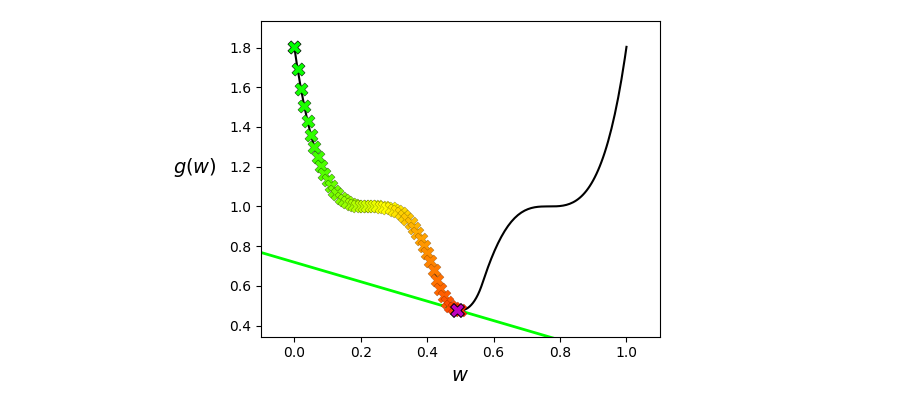
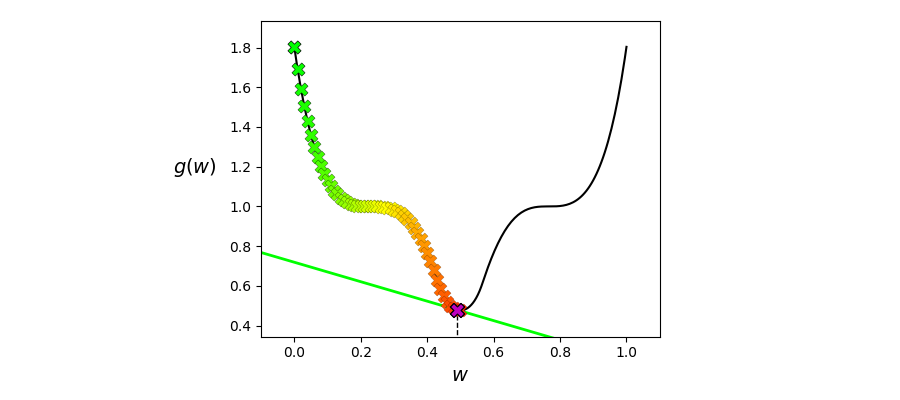
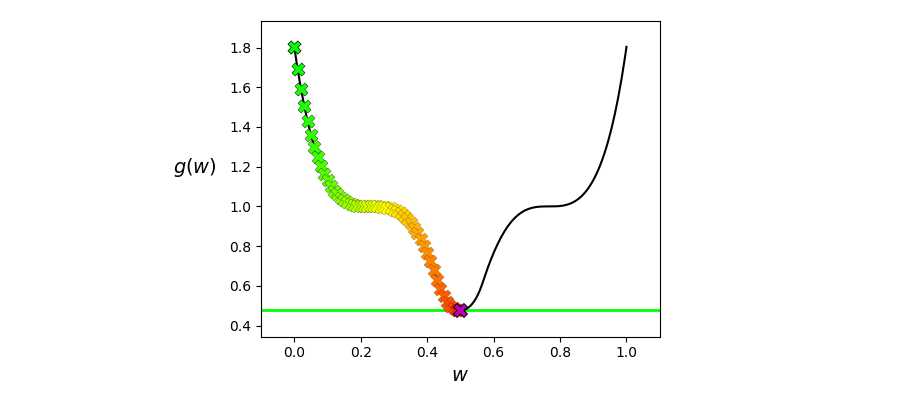
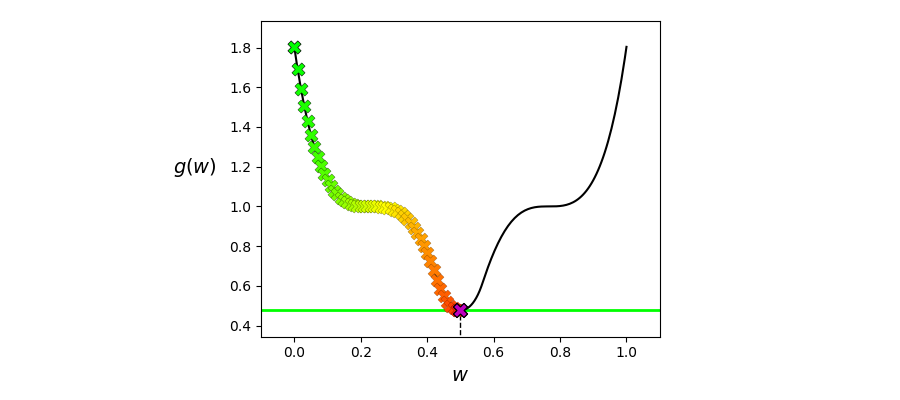
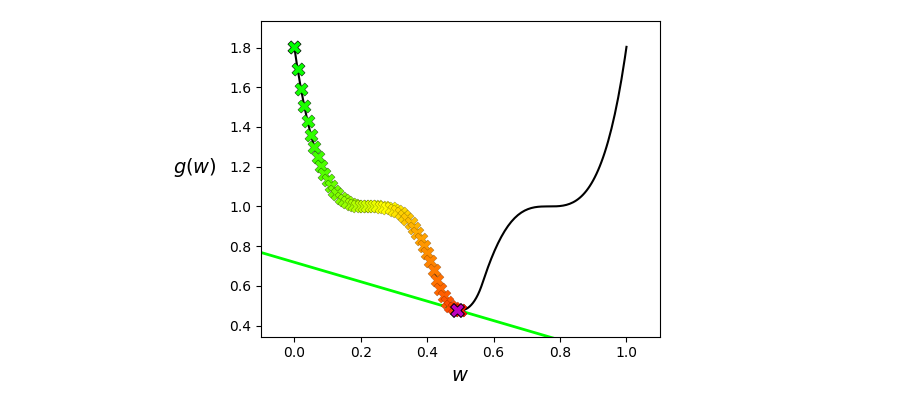
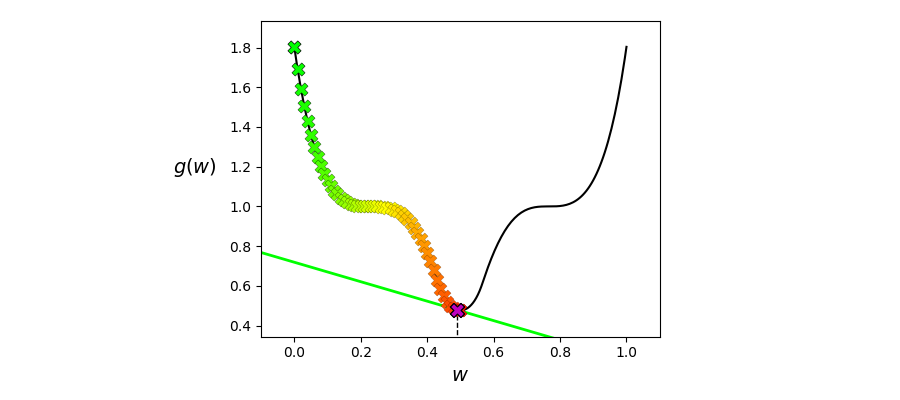
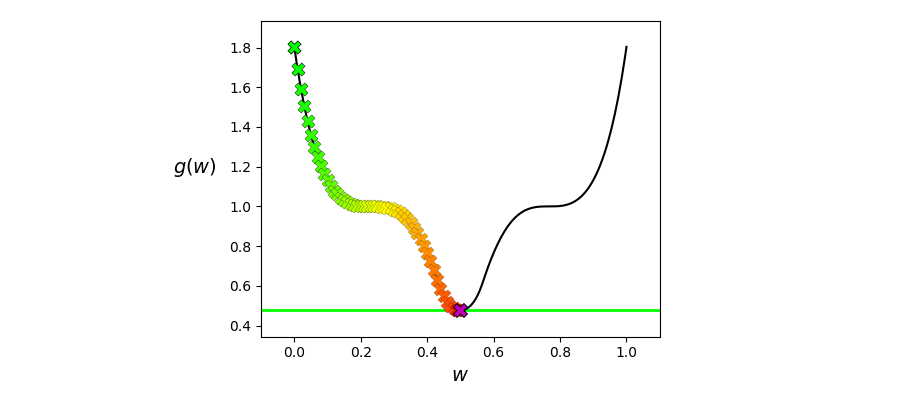
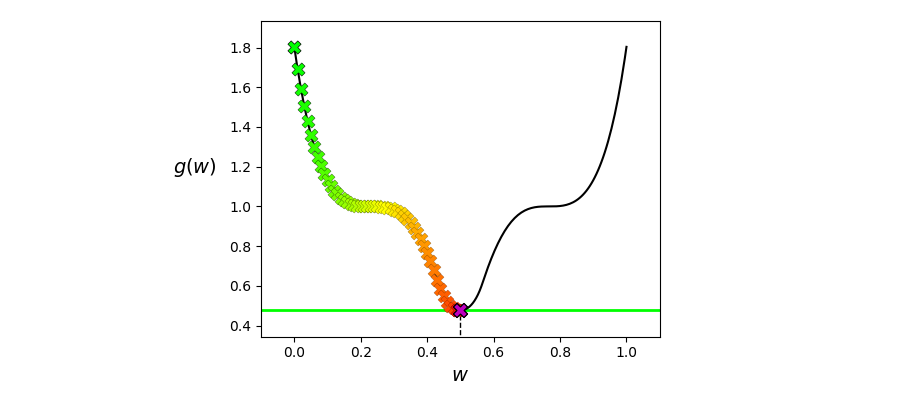
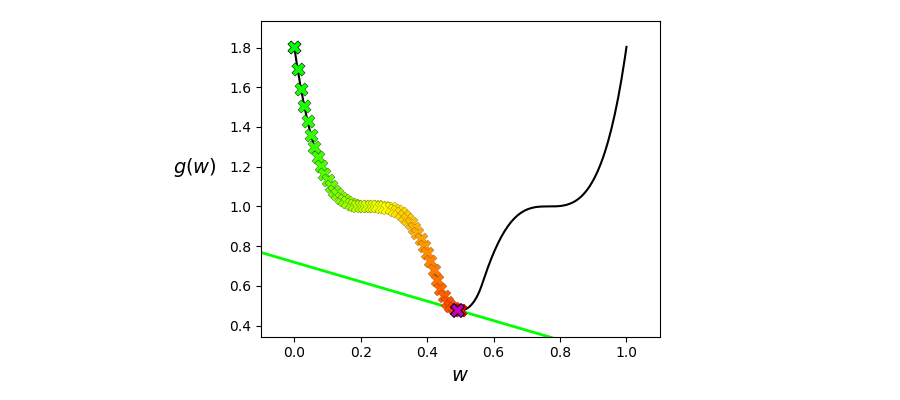
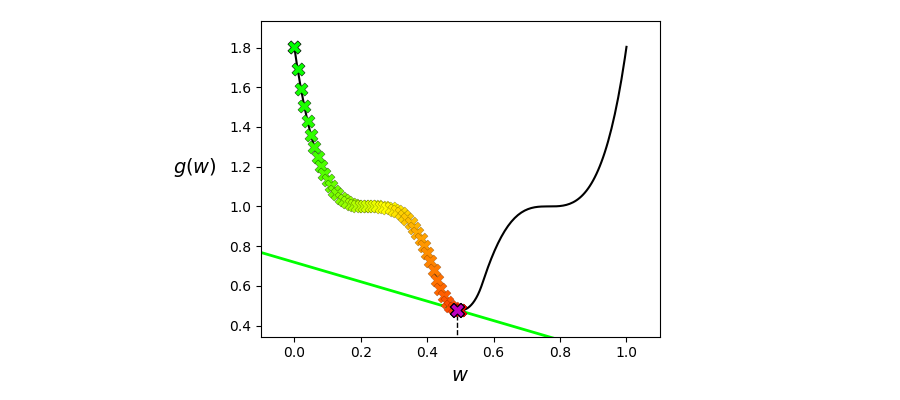
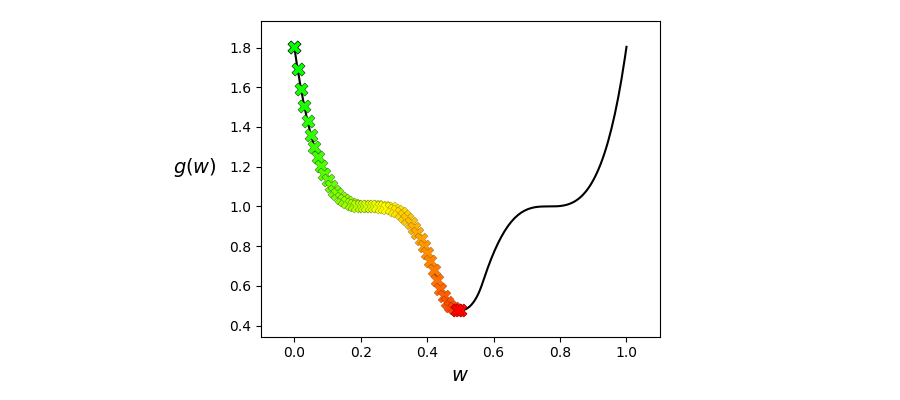

In [52]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.animate_2d(g=g, w_init = 0,steplength = 0.01,max_its = 55,version = 'normalized',wmin = 0,wmax = 1)

<IPython.core.display.Javascript object>


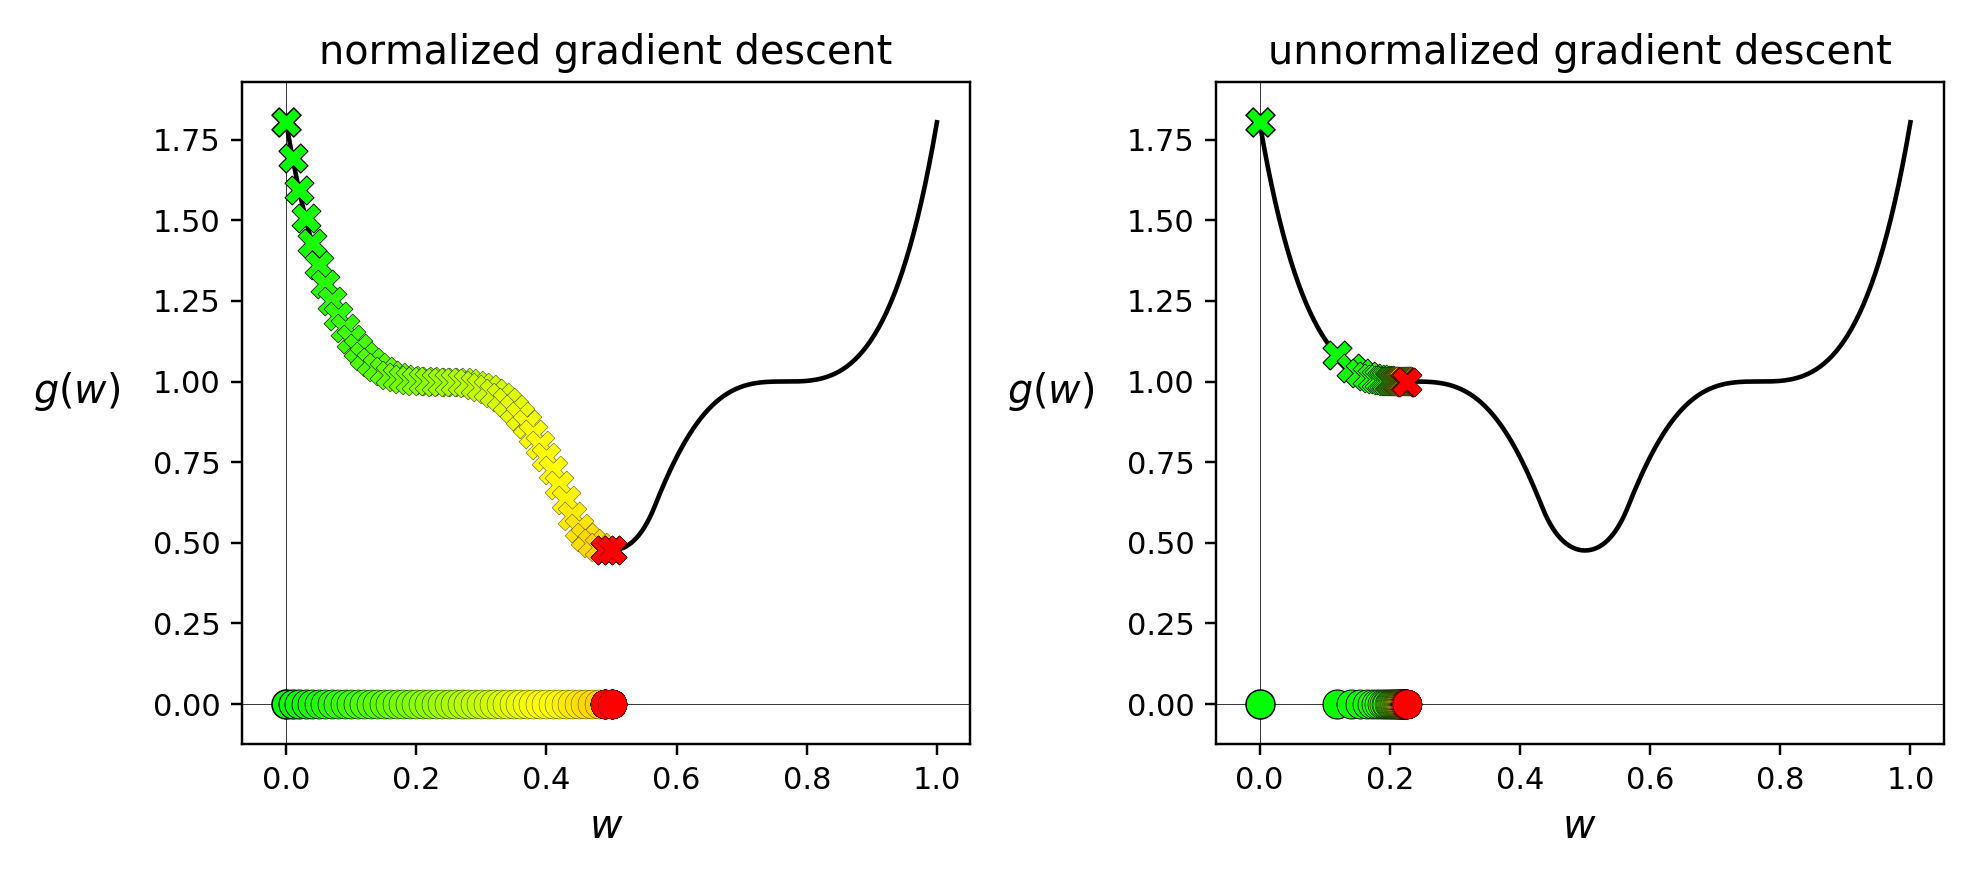

In [3]:
# what function should we play with?  Defined in the next line.
g = lambda w: np.maximum(0,(3*w - 2.3)**3 + 1)**2 + np.maximum(0, (-3*w + 0.7)**3 + 1)**2

# run the visualizer for our chosen input function, initial point, and step length alpha
demo = optlib.gradient_descent_demos.visualizer();

demo.compare_versions_2d(g=g, w_init = 0,steplength = 0.01,max_its = 80,version = 'normalized',wmin = 0,wmax = 1)

- Helps get down long narrow valleys leading to a minimum - even on convex functions

- For example, fitting poly features to a noisy sinusoid dataset

In [53]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten function mom
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist=[]
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm

        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))     

    return w_hist

In [54]:
# compare cost to counting
def compare_regression_histories(histories,cost_func):
    ##### setup figure to plot #####
    # initialize figure
    fig = plt.figure(figsize = (9,3))

    # create subplot with 3 panels, plot input function in center plot
    gs = gridspec.GridSpec(1, 1) 
    ax1 = plt.subplot(gs[0]); 
        
    #### compute each cost ###
    cost_vals = []         # cost evaluations
    
    # run through weights, evaluate classification and counting costs, record
    c = 1
    for history in histories:
        cost_vals = []
        for weight in history:
            ### record softmax cost evaluation
            cost = cost_func(weight)
            cost_vals.append(cost)
        
        # plot both classification and counting cost histories
        if c == 1:
            ax1.plot(cost_vals,label = 'unnormalized run' ,linewidth = 4*(0.8)**(c))
        else:
            ax1.plot(cost_vals,label = 'normalized run' ,linewidth = 4*(0.8)**(c))
        c += 1
        
    ax1.set_title('MSE')
    plt.legend(loc='upper right')
    plt.show()

In [55]:
data = np.loadtxt('../../../mlrefined_datasets/nonlinear_superlearn_datasets/noisy_sin_sample.csv',delimiter=',')

# define the input and output of our dataset
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)

In [56]:
# polynomial degree parameter
D = 5

# prediction function
def predict(pt,w):
    # linear combo
    a = w[0] + sum([w[i]*pt**i for i in range(1,D+1)])
    return a

# least squares
def least_squares(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p]
        y_p = y[p]
        cost +=(predict(x_p,w) - y_p)**2
    return cost/float(len(y))

In [31]:
w_init = np.zeros((D+1,1))

# w_init = np.random.randn(2,1)
alpha = 10**(-1)
max_its = 1500

beta = 0
weight_history_1 = gradient_descent(least_squares,w_init,alpha,max_its,beta,version = 'unnormalized')

beta = 0
weight_history_2 = gradient_descent(least_squares,w_init,alpha,max_its,beta,version = 'normalized')

<IPython.core.display.Javascript object>


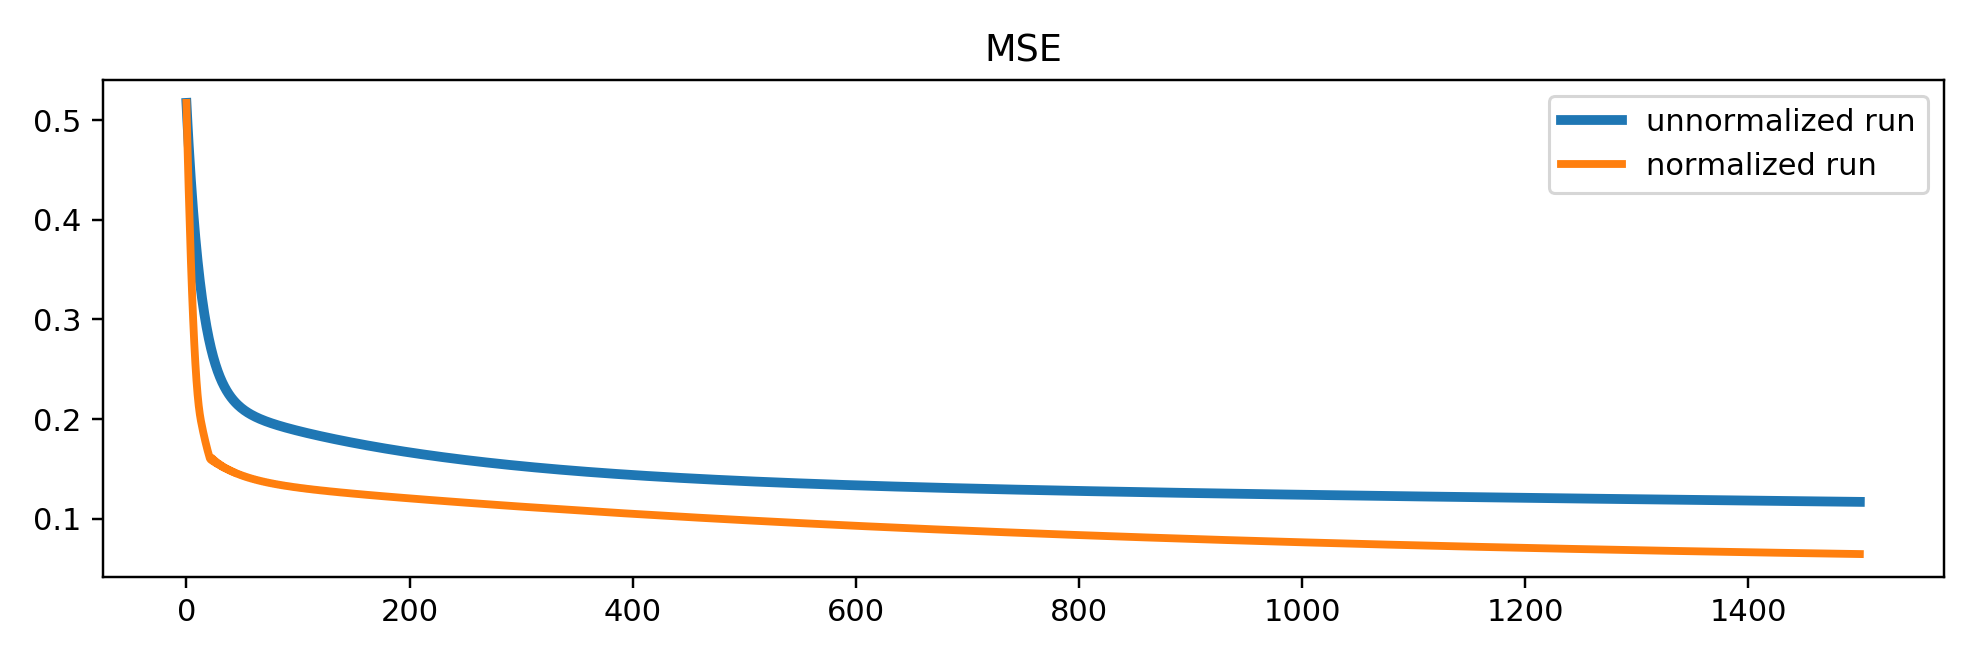

In [32]:
# plot cost function histories
histories = [weight_history_1,weight_history_2]
compare_regression_histories(histories,least_squares)

<IPython.core.display.Javascript object>


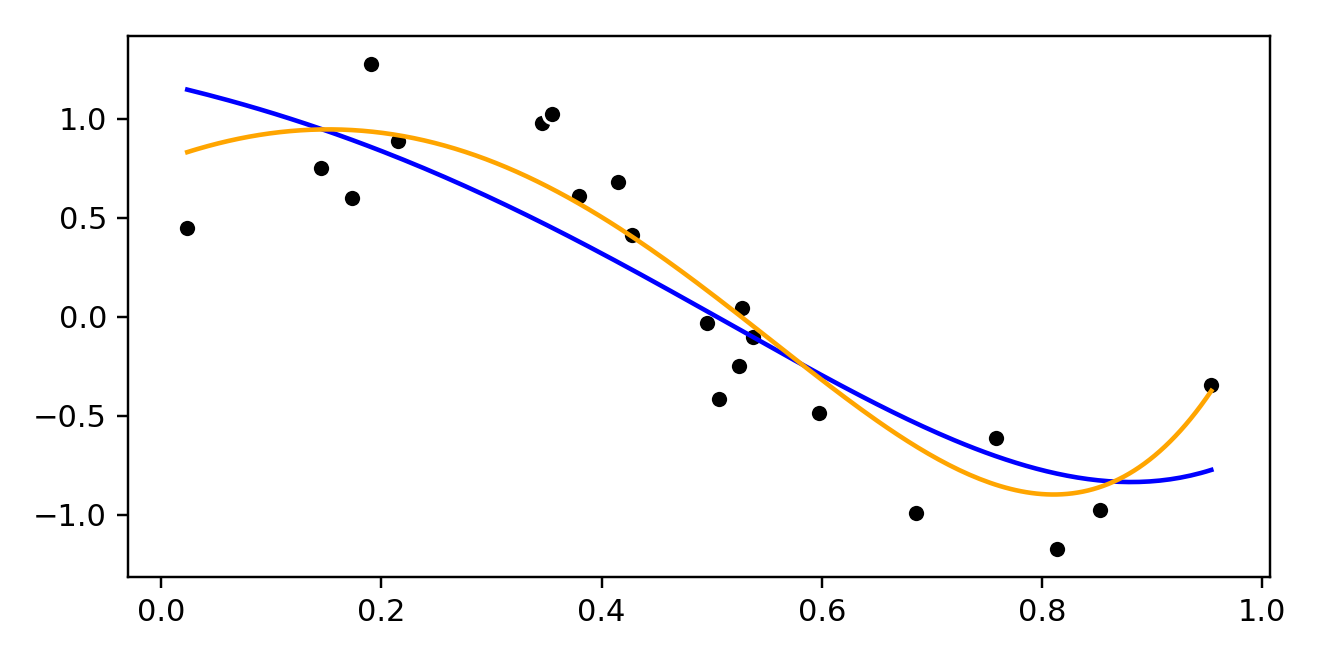

In [33]:
# create figure and plot data
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.scatter(x,y,color = 'k',edgecolor = 'w')

# fit regression model to data
w1 = weight_history_1[-1]
w2 = weight_history_2[-1]

# make fits
x_vals = np.linspace(min(x),max(x),200)
y_vals_1 = [predict(v,w1) for v in x_vals]
y_vals_2 = [predict(v,w2) for v in x_vals]

# plot it
ax.plot(x_vals,y_vals_1,color = 'blue')
ax.plot(x_vals,y_vals_2,color = 'orange')

plt.show()

# Momentum

- Slight modification of gradient descent (either version) to deal with *long narrow valleys* - gradient descent *zig-zags around* in these areas

- Occur in both convex and non-convex cost functions

- Basic idea: add weighted difference of previous weight updates to even out the zig-zagging

- e.g., for unnormalized version of gradient descent

\begin{equation}
\mathbf{w}^{k+1} = \mathbf{w}^k - \alpha \nabla g\left(\mathbf{w}^k\right) + \beta \left(\mathbf{w}^{k} - \mathbf{w}^{k-1}\right)
\end{equation}

- e.g., for unnormalized version of gradient descent ( $\beta \in (0,1)$)

\begin{equation}
\mathbf{w}^{k+1} = \mathbf{w}^k - \alpha \nabla g\left(\mathbf{w}^k\right) + \beta \left(\mathbf{w}^{k} - \mathbf{w}^{k-1}\right)
\end{equation}

<p><img src= 'momentum_fig.png' width="80%" height="60%" alt=""/></p>

- Works the same for normalized gradient descent as well

- Momentum often written in equivalent manner but more mysterious mannar (see notes for details)

\begin{equation}
\begin{array}
\
\mathbf{z}^{k+1} = \beta\,\mathbf{z}^{k} + \nabla g\left(\mathbf{w}^k\right) \\
\mathbf{w}^{k+1} = \mathbf{w}^{k} - \alpha \, \mathbf{z}^{k+1}
\end{array}
\end{equation}

# Momentum examples

- For example, take the quadratic 

\begin{equation}
g(\mathbf{w}) = a + \mathbf{b}^T\mathbf{w} + \mathbf{w}^T\mathbf{C}\mathbf{w}
\end{equation}

where $a = 0$, $\mathbf{b} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$, and $\mathbf{C} = \begin{bmatrix} 1\,\,0 \\ 0 \,\, 12\end{bmatrix}$

- Use unnormalized descent, $\alpha = 0.1$, and $beta = 0.3$

In [57]:
# define constants for a N=2 input quadratic
a = 0
b = 0*np.ones((2,1))
C = np.array([[1,0],[0,12]])

# a quadratic function defined using the constants above
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

In [58]:
w_init = np.ones((2,1))
w_init[1] = 0.5
w_init[0] = 8

# w_init = np.random.randn(2,1)
alpha = 8*10**(-2)
max_its = 13
version = 'unnormalized'

# use momentum with beta = 0
beta = 0
weight_history_1 = gradient_descent(g,w_init,alpha,max_its,beta,version)

# use momentum with beta = 0.9
beta = 0.3
weight_history_4 = gradient_descent(g,w_init,alpha,max_its,beta,version)

<IPython.core.display.Javascript object>


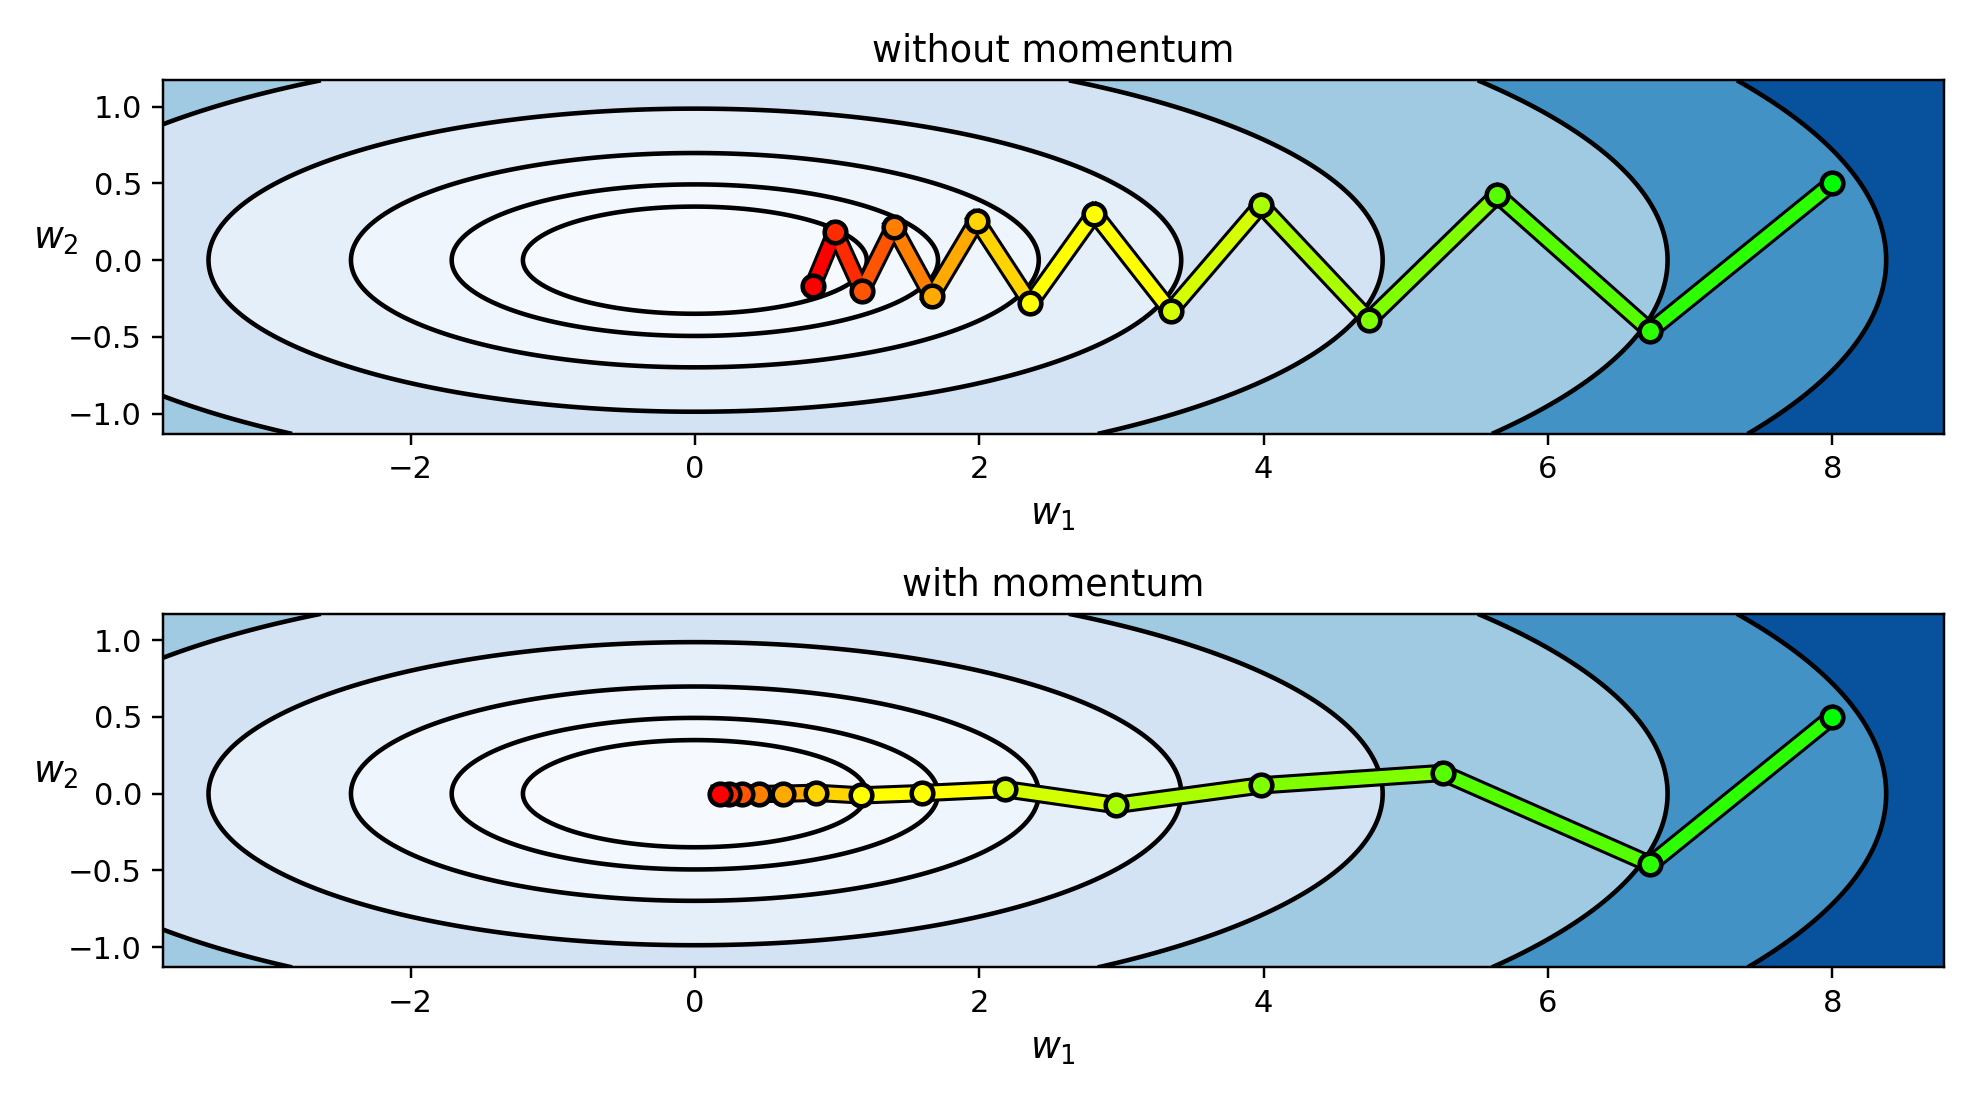

In [41]:
# visualize
import contour_run_comparison
demo = contour_run_comparison.Visualizer()
demo.show_paths(g, weight_history_1,weight_history_4,num_contours = 20)

- For example, take the quadratic 

\begin{equation}
g(\mathbf{w}) = a + \mathbf{b}^T\mathbf{w} + \mathbf{w}^T\mathbf{C}\mathbf{w}
\end{equation}

where $a = 0$, $\mathbf{b} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$, and $\mathbf{C} = \begin{bmatrix} 0\,\,0 \\ 0 \,\, 12\end{bmatrix}$

In [59]:
# define constants for a N=2 input quadratic
a = 0
b = 2*np.ones((2,1))
b[1] = 0
C = np.array([[0,0],[0,12]])

# a quadratic function defined using the constants above
g = lambda w: (a + np.dot(b.T,w) + np.dot(np.dot(w.T,C),w))[0]

In [60]:
w_init = np.ones((2,1))
w_init[1] = 2
w_init[0] = 12

# w_init = np.random.randn(2,1)
alpha = 8.3*10**(-2)
max_its = 30
version = 'unnormalized'

# use momentum with beta = 0
beta = 0
weight_history_1 = gradient_descent(g,w_init,alpha,max_its,beta,version)

# use momentum with beta = 0.8
beta = 0.7
weight_history_2 = gradient_descent(g,w_init,alpha,max_its,beta,version)

<IPython.core.display.Javascript object>


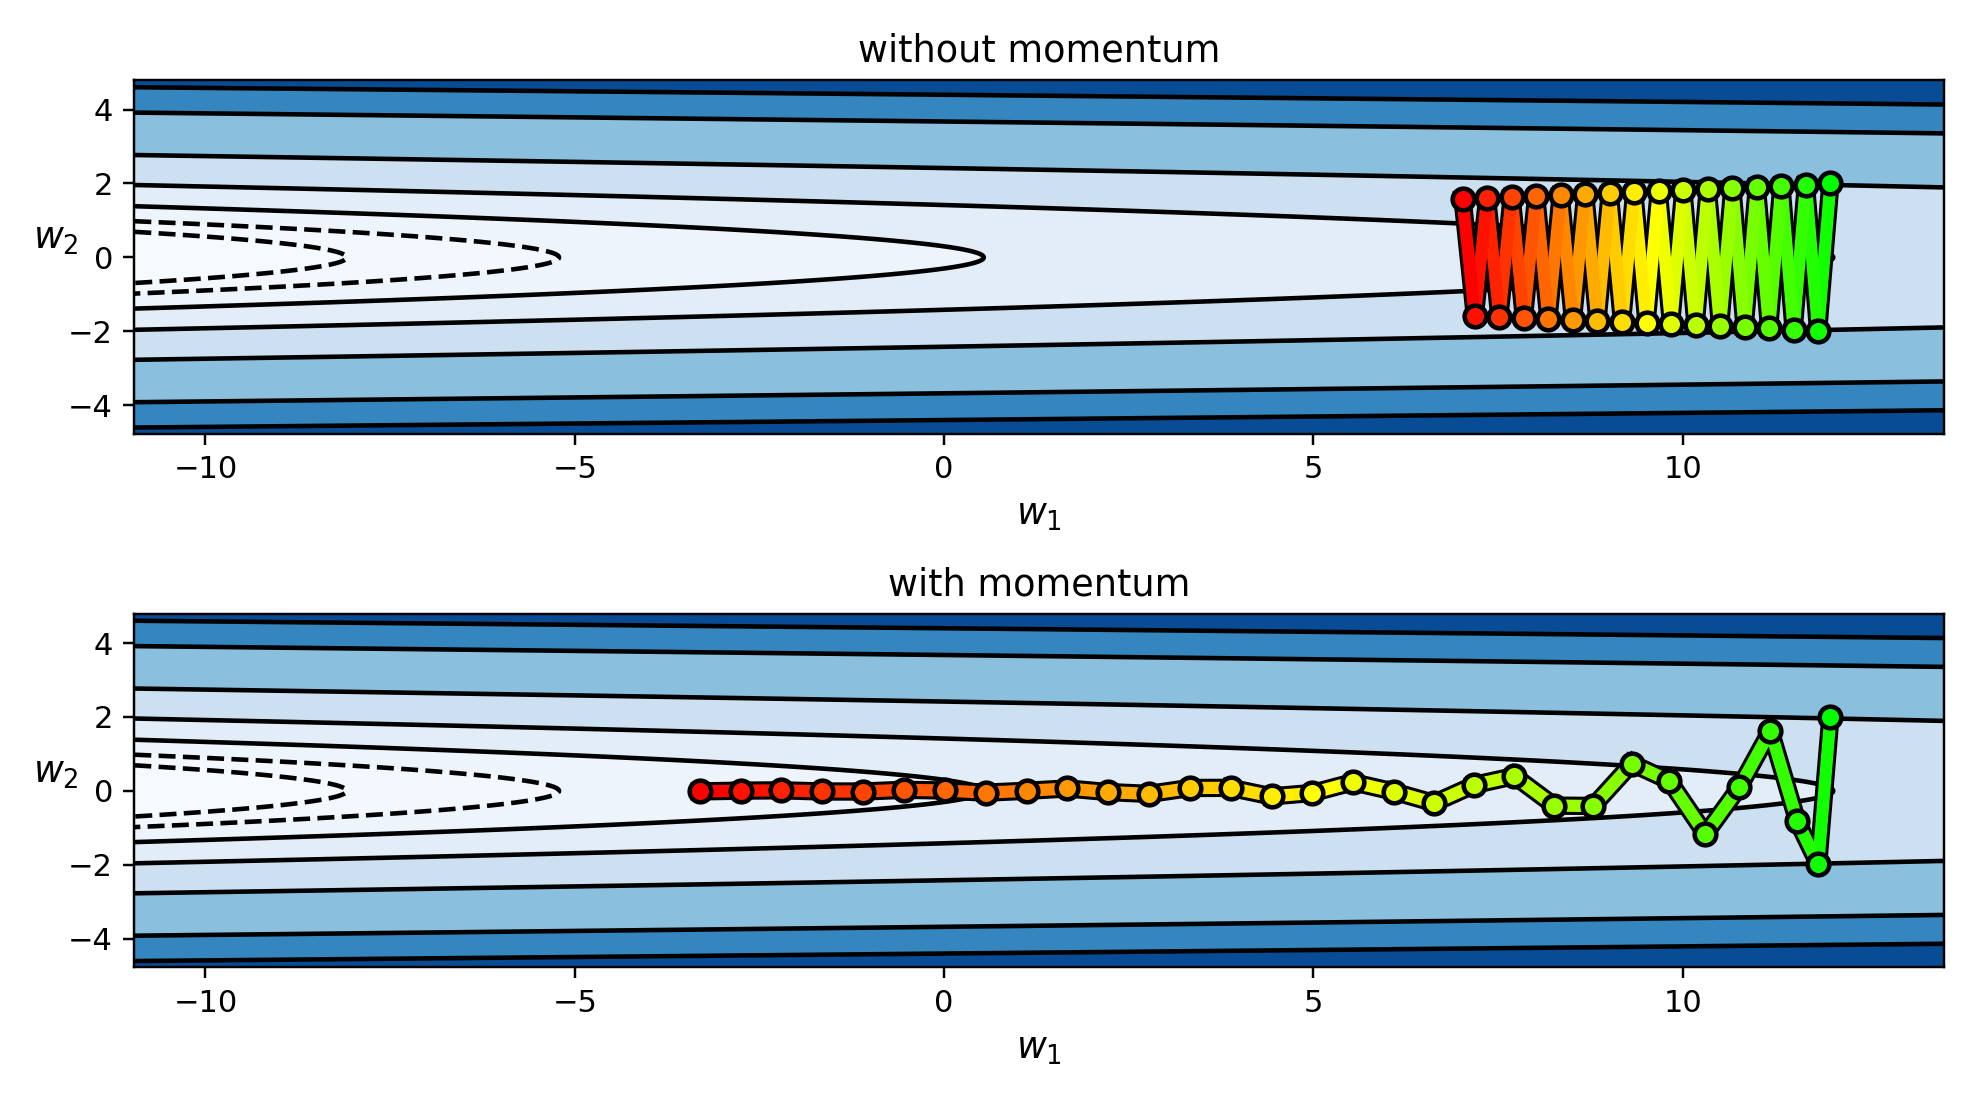

In [44]:
# visualize
demo = contour_run_comparison.Visualizer()
demo.show_paths(g, weight_history_1,weight_history_2,num_contours = 20)

- 2 class classification

In [61]:
# tanh non-convex logistic least squares cost function
def tanh_least_squares(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        cost +=(np.tanh(w[0] + w[1]*x_p) - y_p)**2
    return cost

# load in dataset
data = np.loadtxt('../../../mlrefined_datasets/superlearn_datasets/2d_classification_data_v1.csv')

# define the input and output of our dataset
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)

In [62]:
w_init = np.zeros((2,1))
w_init[0] = 0
w_init[1] = 0
# w_init = np.random.randn(2,1)
alpha = 1
max_its = 25
version = 'normalized'

# use momentum with beta = 0
beta = 0
weight_history_1 = gradient_descent(tanh_least_squares,w_init,alpha,max_its,beta,version)


# use momentum with beta = 0.9
beta = 0.99
weight_history_4 = gradient_descent(tanh_least_squares,w_init,alpha,max_its,beta,version)


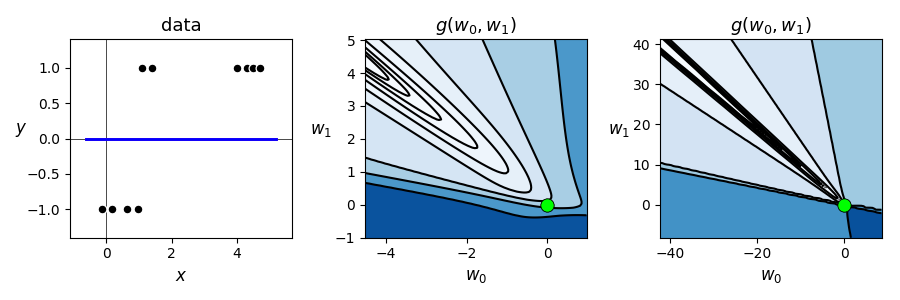
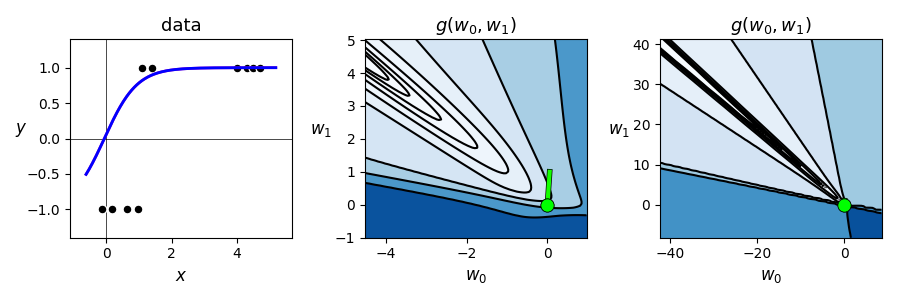
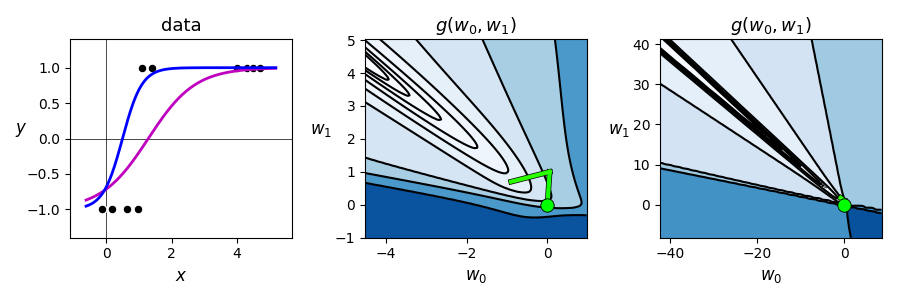
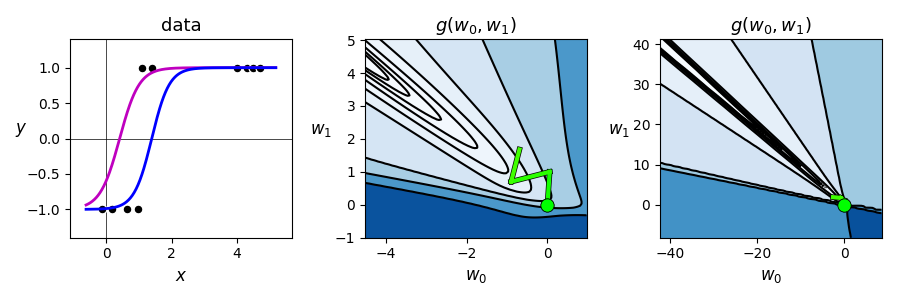
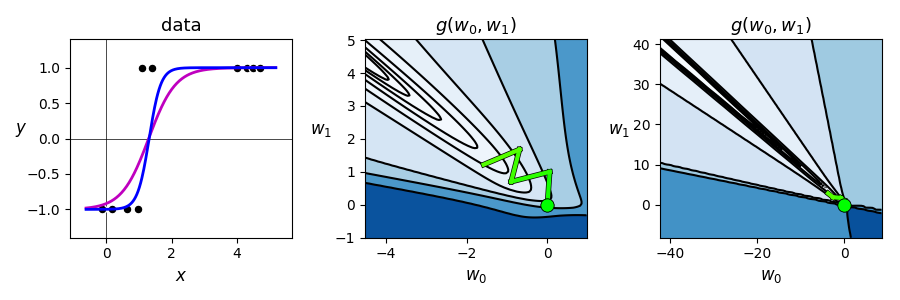
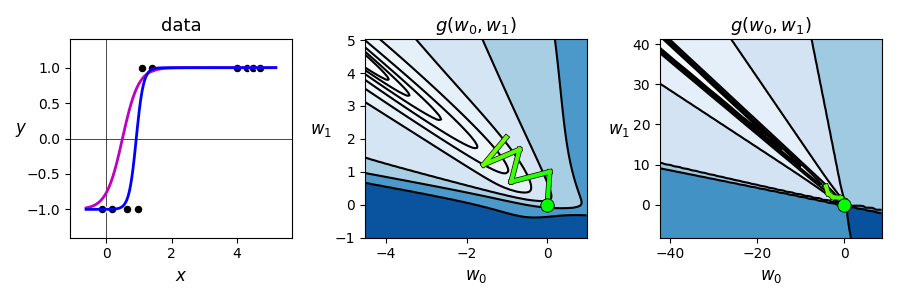
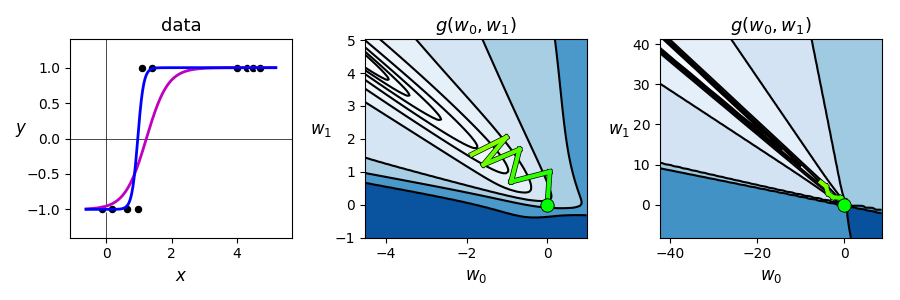
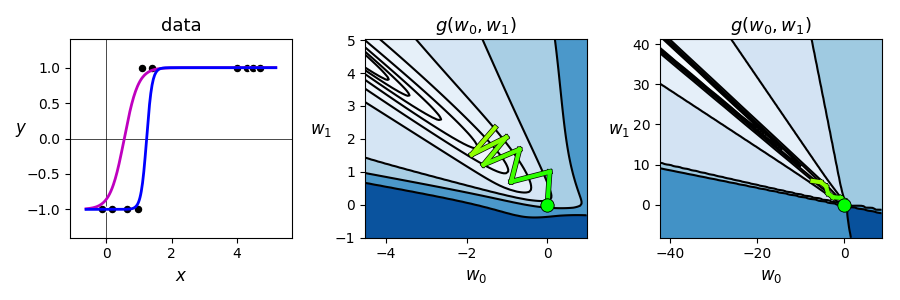
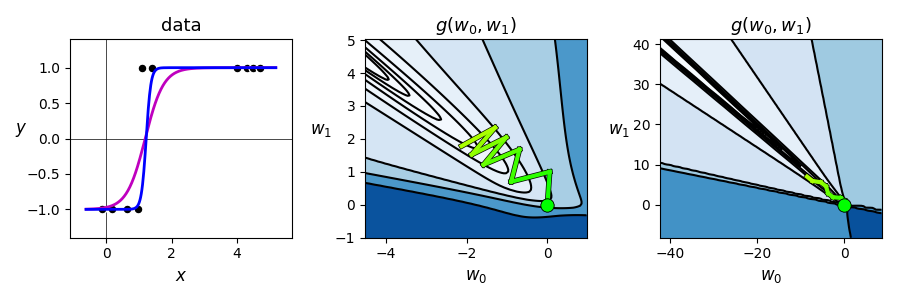
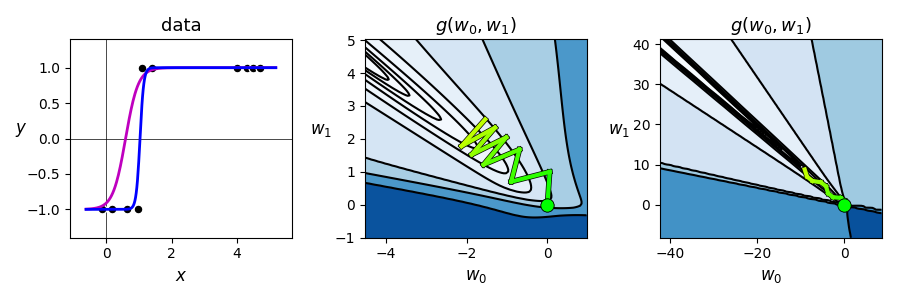
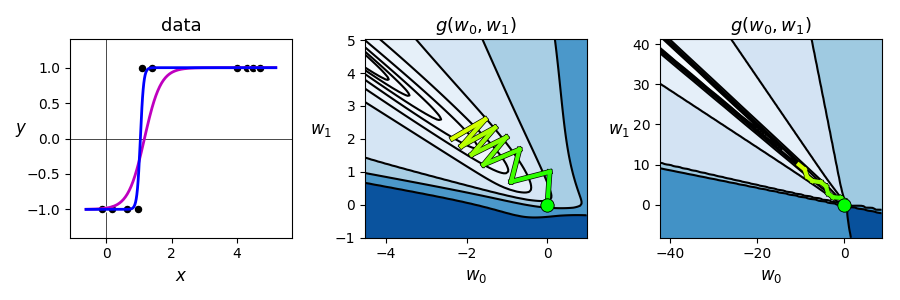
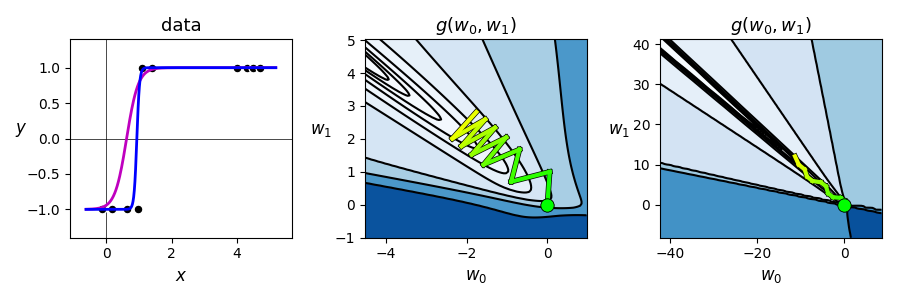
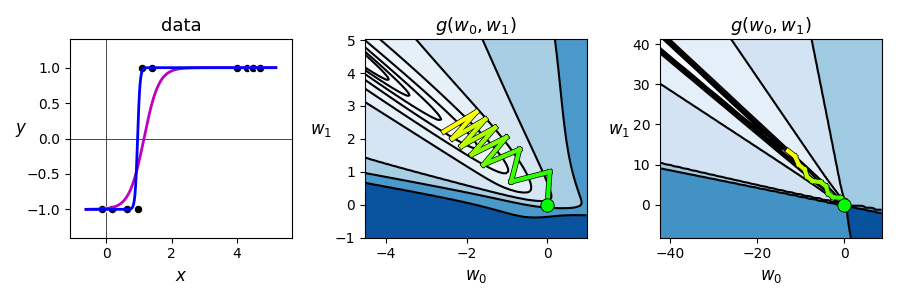
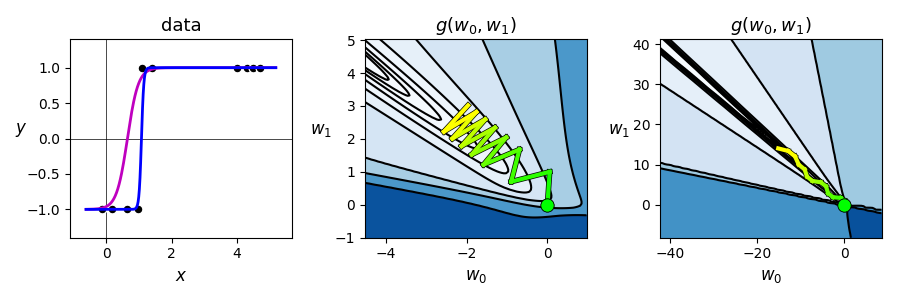
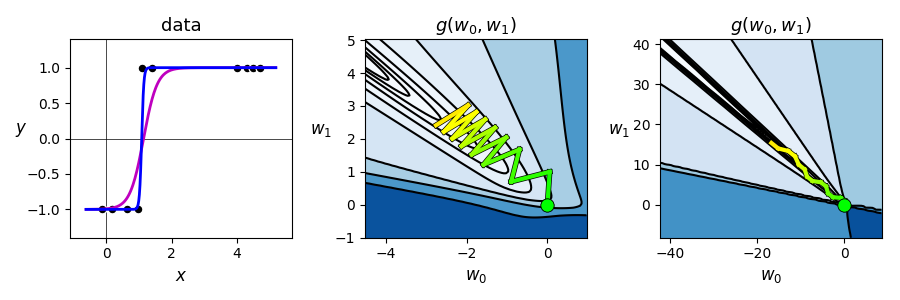
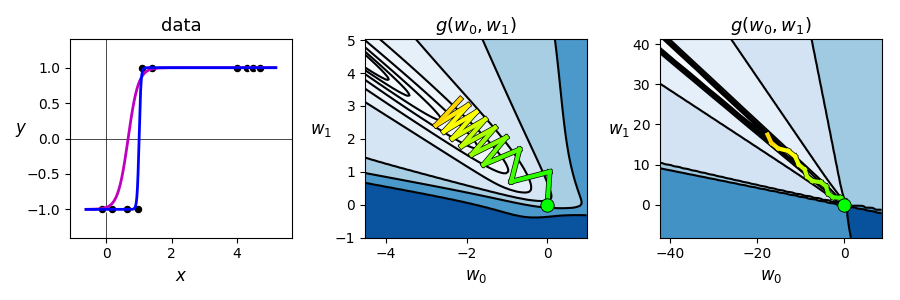
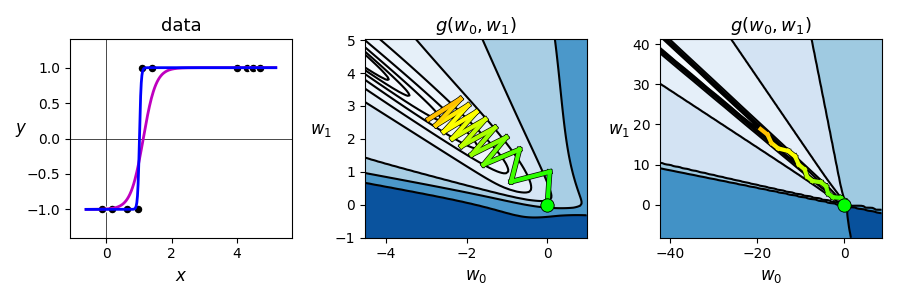
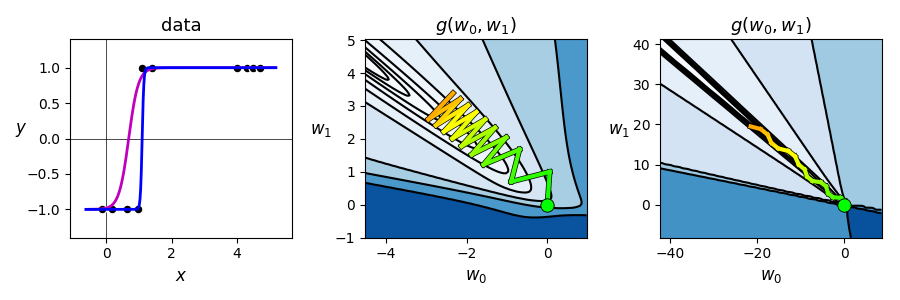
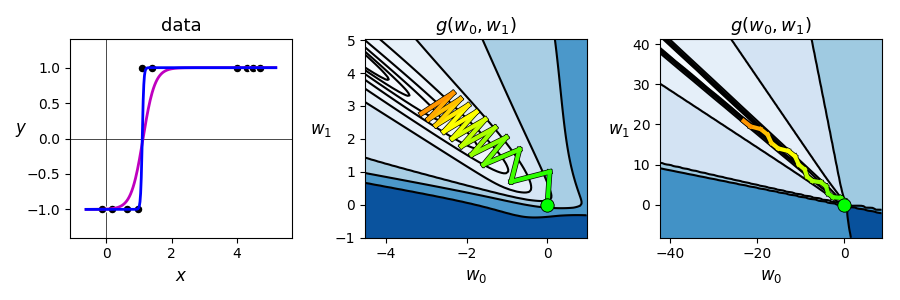
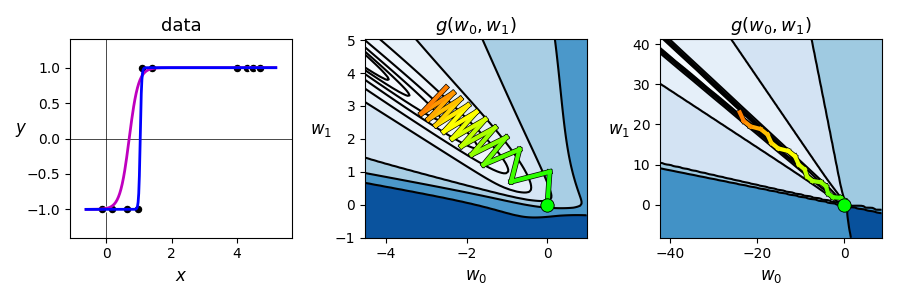
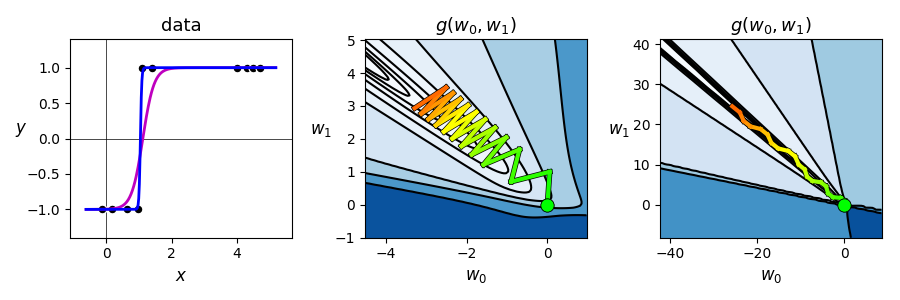
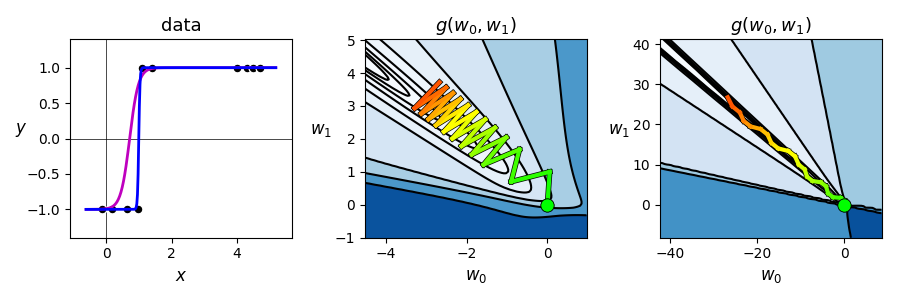
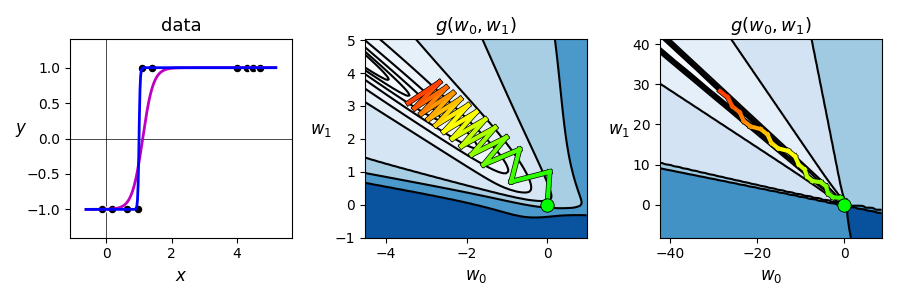
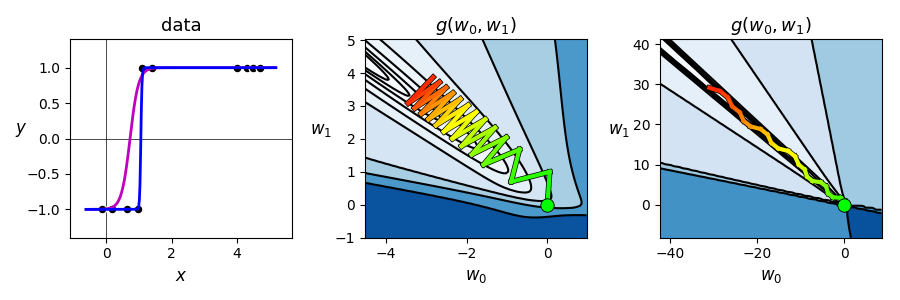
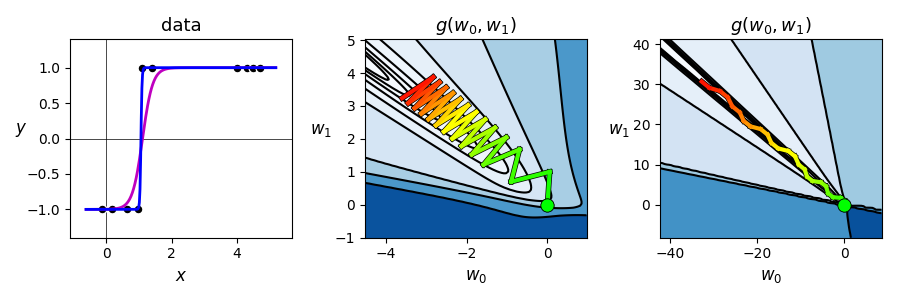
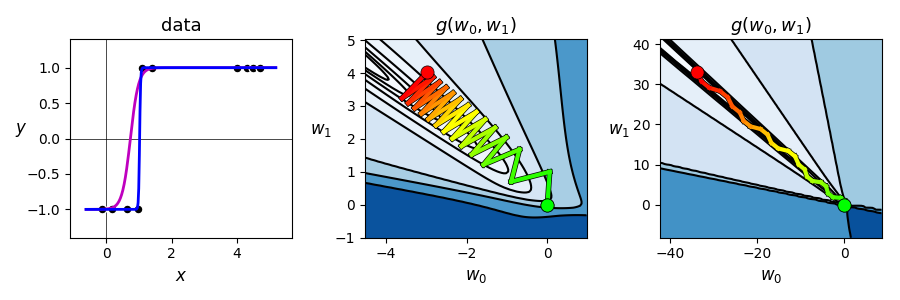

In [63]:
import classification_2d_demos_v2

# create instance of logisic regression demo and load in data, cost function, and descent history
demo3 = classification_2d_demos_v2.Visualizer(data,tanh_least_squares)

# animate descent process
demo3.animate_runs(weight_history_1,weight_history_4,num_contours = 25)